## Importing Necessary Libraries

Importing all the necessary libraries required.

In [109]:
import os
import math
import time
import copy
import random
import numpy as np
from tqdm import tqdm
from datetime import datetime
# from torchviz import make_dot
import matplotlib.pyplot as plt

import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from PIL import Image

from pycocotools.coco import COCO
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F

from transformers import AutoTokenizer, AutoModel, pipeline

from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from pytorch_metric_learning import losses

import faiss

## Configure Data and Model

In this section set the data paths and other configurations for `trainloader`, `valloader`, `valset1` and `valset2`   (`valset1` contains the BottomsUp features and `valset2` contains the BERT features which are meant for evaluation) as follows:
- `root_dir`: Path to directory for images
- `ann_path`: Path to .json file containing annotations
- `feat_dir`: Path to directory containing BottomsUp image features for each image
- `text_dir`: Path to directory containing BERT's textual features for each annotation
- `batch_size`: The batch size for train loader

I am using the **Flickr30k Dataset**.

In [110]:
# Train DataLoader Configurations
trainloader_args = {
  'root_dir': "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/flickr30k_images/flickr30k_images/flickr30k_images",
  'ann_path': "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/flickr30k_annotations/train.json",
  'feat_dir': "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/bottom_up",
  'text_dir': "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/bert_features",
  'batch_size': 128,
  'num_workers': 0
}

# Validation DataLoader Configurations
valloader_args = {
  'root_dir': "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/flickr30k_images/flickr30k_images/flickr30k_images",
  'ann_path': "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/flickr30k_annotations/val.json",
  'feat_dir': "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/bottom_up",
  'text_dir': "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/bert_features",
  'batch_size': 128, 
  'num_workers': 0
}

# Dataset for Metric Evaluation -Here I use the validation set itself for metric evaluation
valset1_args = { # BottomUp Features
  'feat_dir': "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/bottom_up",
  'ann_path': "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/flickr30k_annotations/val.json"
}

# Dataset for Metric Evaluation -Here I use the validation set itself for metric evaluation
valset2_args = { # BERT Features
  'feat_dir': "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/bert_features",
  'ann_path': "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/flickr30k_annotations/val.json"
}

In [111]:
device = torch.device('mps') # Set it to 'cuda' for gpu or 'cpu' for cpu or 'mps' for M1

## Data Preparation

I define the class that will handle the custom datasets and dataloaders. The format in which the dataset of images and the annotation files are present is according to the COCO guidelines.

Make sure to have extracted the image and annotation features for the following class to function properly. The data directory tree is being provided below for reference. Suppose the folder containing all the data is named `data`.
```
data ───────────────────────────> Contains the Dataset and the relevant pre-computed features
├── bert_features ──────────────> Contains the BERT Features for the annotations in the Flickr30k Dataset
│   ├── 0.npz
│   ├── 1.npz
│   ├── 2.npz
│   ├── .....
│   └── 155069.npz ─────────────> BERT Features for the annotation text with ann_id = 155069
├── bottom_up ──────────────────> Contains the Bottom-up Features for all the annotations in the Flickr30k
│   ├── data_att
│   │   ├── 1000092795.npz
│   │   ├── 10002456.npz
│   │   ├── ...
│   │   └── 998845445.npz ──────> Bottom-Up Features for the image with image_id = 998845445
│   └── data_box
│       ├── 1000092795.npz
│       ├── 10002456.npz
│       ├── ...
│       └── 998845445.npz ──────> Bounding Box Features for the image with image_id = 998845445
├── flickr30k_annotations ──────> Contains the Annotation Files for the Flickr30k Dataset
│   ├── flickr30k_all.json ─────> Annotation File for the entire Flickr30k Images
│   ├── train.json ─────────────> Annotation File for the train Flickr30k Images 
│   └── val.json ───────────────> Annotation File for the validation Flickr30k Images 
└── flickr30k_images ───────────> Contains the Image Files for the Flickr30k Dataset
    └── flickr30k_images ───────> Ignore this directory
        ├── 1000092795.jpg
        ├── 10002456.jpg ───────> Images from the Flickr30k Dataset
        ├── ...
        └── 998845445.jpg
```

Above the name of the `<ann_id>.npz` in `bert_features` file corresponds to the annotation with the `ann_id` as `<ann_id>` and the name of the  `<image_id>.npz` in `bottom_up/data_att` and `bottom_up/data_box` corresponds to the image with the `image_id` as `<image_id>` in the `flickr30k_all.json` file which stores the data as per the `COCO .json` guidelines.

### Bottom-Up Features Storage

Below we see how the data in the .npz files are organized. `data_box` folder contains the coordinates of the bounding box.

In [112]:
data1 = np.load('/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/bottom_up/data_box/36979.npz')

In [113]:
data1['feat'].shape

(36, 5)

In [114]:
data1['feat'][:5] # First 5 out of 36 bounding boxes for one of the images

array([[103.83716583,  55.41079712, 144.81468201,  99.13117218,
        545.        ],
       [110.3965683 , 146.09048462, 361.76617432, 286.25769043,
        106.        ],
       [135.88619995, 173.63604736, 415.54824829, 335.27069092,
        106.        ],
       [251.71195984,  40.11985779, 356.18463135, 211.74856567,
         50.        ],
       [  0.        ,  70.35986328, 101.263237  , 179.20793152,
        119.        ]])

`data_att` folder contains the features extracted from these bounding box.

In [115]:
data1 = np.load('/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/bottom_up/data_att/36979.npz')

In [116]:
data1['feat'].shape

(36, 2048)

In [117]:
data1['feat'][:5] # First 5 out of 36 bounding boxes' features for the same image as above

array([[0.0000000e+00, 6.2104285e-01, 1.0477988e+00, ..., 0.0000000e+00,
        0.0000000e+00, 2.0651214e-01],
       [5.0457919e-01, 7.7560830e-01, 0.0000000e+00, ..., 0.0000000e+00,
        6.0314050e+00, 5.8209195e+00],
       [2.8219435e-01, 1.8445037e-01, 0.0000000e+00, ..., 0.0000000e+00,
        9.9888259e-01, 7.9883933e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 6.6663906e-02,
        4.0683333e-02, 7.9872423e-01],
       [0.0000000e+00, 0.0000000e+00, 2.4023591e-04, ..., 0.0000000e+00,
        6.2136441e-01, 1.8564485e-01]], dtype=float32)

### BERT Feature Storage

`bert_features` folder contains the BERT-based (more specifically `distil-bert uncased`) features extracted from the annotations.

In [118]:
data1 = np.load('/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/bert_features/0.npz')

In [119]:
data1['feat'].shape

(19, 768)

In [120]:
data1['feat'][:5] # First 5 out of 19 tokens' features for each annotation

array([[ 0.18091495, -0.17293406, -0.10586261, ..., -0.15721308,
         0.6573164 , -0.02420515],
       [ 0.31351984,  0.05622987, -0.24647827, ..., -0.13656305,
         0.58381605, -0.2248309 ],
       [ 0.4589281 ,  0.3011122 , -0.1646451 , ..., -0.35835925,
         0.46185836, -0.71534413],
       [ 0.44939154,  0.27436888, -0.23062916, ..., -0.31810743,
         0.13104717, -0.46463642],
       [ 0.46763006,  0.78821033, -0.14429283, ..., -0.06293612,
         0.5962199 , -0.41637862]], dtype=float32)

### Image Augmentation

I use the following image augmentation to the images from the dataset, which is added to the images before passing to the Faster-RCNN for getting region proposals and for the feature extraction.

In [121]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

class Denormalize(object):
  """
  Denormalize image and boxes for visualization
  """
  
  def __init__(self, mean = MEAN, std = STD, **kwargs):
    self.mean = mean
    self.std = std

  def __call__(self, img, box = None, label = None, mask = None, **kwargs):
    """
    :param img: (tensor) image to be denormalized
    :param box: (list of tensor) bounding boxes to be denormalized, by multiplying them with image's width and heights. Format: (x,y,width,height)
    """
    mean = np.array(self.mean)
    std = np.array(self.std)
    img_show = img.numpy().squeeze().transpose((1,2,0))
    img_show = (img_show * std+mean)
    img_show = np.clip(img_show,0,1)
    return img_show

def get_resize_augmentation(image_size, keep_ratio=False, box_transforms = False):
  """
  Resize an image, support multi-scaling
  :param image_size: shape of image to resize
  :param keep_ratio: whether to keep image ratio
  :param box_transforms: whether to augment boxes
  :return: albumentation Compose
  """

  if not keep_ratio:
    return  A.Compose([
        A.Resize(
            height = image_size[1],
            width = image_size[0]
        )]) 
  else:
    return A.Compose([
        A.LongestMaxSize(max_size=max(image_size)), 
        A.PadIfNeeded(min_height=image_size[1], min_width=image_size[0], p=1.0, border_mode=cv2.BORDER_CONSTANT),
        ])
        

def get_augmentation():
  val_transforms = A.Compose([
      A.Normalize(mean=MEAN, std=STD, max_pixel_value=1.0, p=1.0),
      ToTensorV2(p=1.0)
  ])

  return val_transforms

### Visualization Functions

The following functions are used to visualize the images and the captions from the Dataset as well as retrieval results.

In [122]:
def draw_image_caption(image, text, image_name=None, figsize=(10,10)):

  plt.close('all')
  fig = plt.figure(figsize=figsize)

  if isinstance(image, torch.Tensor):
    image = image.numpy().squeeze().transpose((1,2,0))

  # Display the image
  plt.imshow(image)
  plt.axis('off')
  fig.text(.5, .05, text, ha='center')

  if image_name:
    plt.savefig(image_name, bbox_inches='tight')

  return fig

def draw_retrieval_results(query, top_k_relevant, gt_path=None, save_filename=None, figsize=(10,10)):
  plt.close('all')
  fig=plt.figure(figsize=figsize)

  columns = len(top_k_relevant) + 1
  for i, (image, score) in enumerate(top_k_relevant):
    img = Image.open(image)
    fig.add_subplot(1, columns, i+1)
    plt.imshow(img)
    plt.title(str(score))
    plt.tight_layout()
    plt.axis('off')


  # Plot ground truth
  img = Image.open(gt_path)
  fig.add_subplot(1, columns, columns)
  plt.imshow(img)
  plt.title('Ground Truth')
  plt.tight_layout()
  plt.axis('off')


  if save_filename is not None:
    plt.savefig(save_filename)

  fig.suptitle(query)
  return fig

### Custom Dataset Classes

Following are the custom Dataset classes to handle our data and will serve has an input to our DataLoader for training the model.

#### COCO Dataset

The following is the class that handles the dataset in COCO format. It deals with the raw dataset containing images and captions only, but not the extracted features. The `CocoDataset` class can be used to fetch the data in the form of:
- `image_ids`: IDs of the images in the .json annotation files
- `ann_ids`: IDs for the annotations in the .json annotation files
- `image_names`: Image names
- `ori_imgs`: Original Images
- `imgs`: Transformed Images
- `tgt_texts_raw`: Raw caption texts for each image (Since, there are multiple captions for each image, we select a random caption out of the many for each image)
- `texts`: Should contain the transformed preprocessed caption text, but as of now it returns `tgt_texts_raw`. **TODO!!!**

In [123]:
class CocoDataset(Dataset):
  
  def __init__(self, root_dir, ann_path, image_size=224, keep_ratio=False):

    self.patch_size = 16
    self.root_dir = root_dir
    self.ann_path = ann_path
    self.image_size = [image_size, image_size]

    self.transforms = A.Compose([
      get_resize_augmentation(self.image_size, keep_ratio=keep_ratio),
      get_augmentation()
    ])

    self.coco = COCO(ann_path)
    self.image_ids = self.coco.getImgIds()

  def __len__(self):
    return len(self.image_ids)

  def load_image(self, image_index):
    image_info = self.coco.loadImgs(self.image_ids[image_index])[0]
    image_path = os.path.join(self.root_dir, image_info['file_name'])
    return image_path

  def load_annotations(self, image_index, return_all=False):
    ann_id = self.coco.getAnnIds(imgIds=self.image_ids[image_index])

    if not return_all:
      ann_id = ann_id[0] # A random annotation out of the many annotations is returned
      anns = self.coco.loadAnns(ann_id)[0]['caption']
    else:
      anns = self.coco.loadAnns(ann_id)
      anns = [i['caption'] for i in anns]
    return anns, ann_id

  def __getitem__(self, index):
    image_id = self.image_ids[index]
    image_path = self.load_image(index)
    text, ann_id = self.load_annotations(index)

    return {
      'image_id': image_id,
      'ann_id': ann_id,
      'image_path': image_path,
      'text': text,
  }

  def load_augment(self, image_path):
    ori_img = cv2.imread(image_path)
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    image = ori_img.astype(np.float32)
    image /= 255.0
    image = self.transforms(image=image)['image']
    return image, ori_img

  def collate_fn(self, batch):

    image_paths = [s['image_path'] for s in batch]
    image_ids = [s['image_id'] for s in batch]
    ann_ids = [s['ann_id'] for s in batch]

    image_names = []
    ori_imgs = []
    for image_path in image_paths:
      image_names.append(os.path.basename(image_path))

    imgs = []
    for image_path in image_paths:
      image, ori_img = self.load_augment(image_path)
      imgs.append(image)
      ori_imgs.append(ori_img)
    feats = torch.stack(imgs)

    texts = [s['text'] for s in batch]

    return {
      'image_ids': image_ids,
      'ann_ids': ann_ids,
      'image_names': image_names,
      'ori_imgs': ori_imgs,
      'imgs': feats,
      'tgt_texts_raw': texts,
      'texts': texts,
    }


  def visualize_item(self, index = None, figsize=(15,15)):
    """
    Visualize an image with its captions by index
    """

    if index is None:
      index = random.randint(0,len(self.coco.imgs)-1)
    image_path = self.load_image(index)
    image_name = os.path.basename(image_path)
    image, _ = self.load_augment(image_path)

    texts, _ = self.load_annotations(index, return_all=True)

    normalize = False
    if self.transforms is not None:
      for x in self.transforms.transforms[1]:
        if isinstance(x, A.Normalize):
          normalize = True
          denormalize = Denormalize(mean=x.mean, std=x.std)

    # Denormalize and reverse-tensorize
    if normalize:
      image = denormalize(img = image)

    self.visualize(image, texts, figsize = figsize, img_name= image_name)

  def visualize(self, img, texts, figsize=(15,15), img_name=None):
    """
    Visualize an image with its captions
    """

    text = []
    for i, t in enumerate(texts):
      text.append(f"{i+1}. {t}")
    text = "\n".join(text)
    fig = draw_image_caption(img, text, figsize=figsize)

    if img_name is not None:
      plt.title(img_name)
    plt.show()

  def count_dict(self, types = 1):
    """
    Count text length frequencies
    """
    cnt_dict = {}
    if types == 1: # Text length Frequencies
      for image_id in range(len(self.image_ids)):
        texts = self.load_annotations(image_id, return_all=True)
        for text in texts:
          text_length = len(text)
          if text_length not in cnt_dict.keys():
            cnt_dict[text_length] = 0
          cnt_dict[text_length] += 1

    return cnt_dict

  def plot(self, figsize = (8,8), types = ["length"]):
    """
    Plot distribution
    """
    ax = plt.figure(figsize = figsize)
    num_plots = len(types)
    plot_idx = 1

    if "length" in types:
      ax.add_subplot(num_plots, 1, plot_idx)
      plot_idx +=1
      cnt_dict = self.count_dict(types = 1)
      plt.title("Total texts: "+ str(sum(list(cnt_dict.values()))))
      bar1 = plt.bar(list(cnt_dict.keys()), list(cnt_dict.values()), color=[np.random.rand(3,) for i in range(len(cnt_dict.keys()))])
      for rect in bar1:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom')

    plt.show()

  def __str__(self): 
    s1 = "Number of images: " + str(len(self.image_ids)) + '\n'
    s2 = "Number of texts: " + str(len(self.coco.getAnnIds())) + '\n'
    return s1 + s2

#### Numpy Features Dataset

Let's understand the structure of the data in detail. For each data point in the dataset, we have extracted two types of features using pretrained model, which are as follows:
- Visual Features: Bounding Box Coordinates for Regions Proposed by Faster-RCNN's RPN and the ResNet model was used to extract the features for all these image portions inside the bounding boxes.
- Textual Features: Textual features were obtained using BERT for each caption. This is done for all the multiple captions are present for each image.

Now, in the `collate_fn` used when generating batch data from the DataLoader, we use padding upto the maximum length of the textual features for all sentences in that batch. This is handled by the `make_feature_batch` function below.

In [124]:
def make_feature_batch(features,  pad_token=0):
  """
  List of features,
  each feature is [K, model_dim] where K is number of objects of each image
  This function pad max length to each feature and tensorize, also return the masks
  """
  model_dim = features[0].shape[-1]

  # Find maximum length
  max_len=0
  for feat in features:
    feat_len = feat.shape[0]
    max_len = max(max_len, feat_len)

  # Init batch
  batch_size = len(features)
  batch = np.ones((batch_size, max_len, model_dim))
  batch *= pad_token

  # Copy data to batch
  for i, feat in enumerate(features):
    feat_len = feat.shape[0]
    batch[i, :feat_len, :] = feat

  batch = torch.from_numpy(batch).type(torch.float32)
  return batch 

The following class handles the dataset for both the precomputed numpy features for images and texts together.

In [125]:
class NumpyFeatureDataset(Dataset):
  
  def __init__(self, root_dir, ann_path, feat_dir, text_dir):

    self.root_dir = root_dir
    self.ann_path = ann_path
    self.feat_dir = feat_dir
    self.text_dir = text_dir
    self.coco = COCO(ann_path)
    self.image_ids = self.coco.getImgIds()

  def __len__(self):
    return len(self.image_ids)

  def load_image(self, image_index):
    image_info = self.coco.loadImgs(self.image_ids[image_index])[0]
    image_path = os.path.join(self.root_dir, image_info['file_name'])
    return image_path

  def load_image_by_id(self, image_id):
    image_infos = self.coco.loadImgs(image_id)
    image_path = [os.path.join(self.root_dir, i['file_name']) for i in image_infos]
    return image_path

  def load_annotations_by_id(self, ann_id):
    anns = self.coco.loadAnns(ann_id)
    anns = [i['caption'] for i in anns]
    return anns

  def load_numpy(self, image_index):
    image_info = self.coco.loadImgs(self.image_ids[image_index])[0]
    npy_path = os.path.join(self.feat_dir, 'data_att', image_info['file_name'][:-4]+'.npz')
    npy_loc_path = os.path.join(self.feat_dir, 'data_box', image_info['file_name'][:-4]+'.npz')
    return npy_path, npy_loc_path

  def load_annotations(self, image_index, return_all=False):
    ann_id = self.coco.getAnnIds(imgIds=self.image_ids[image_index])

    if not return_all:
        ann_id = ann_id[0] # returns a random caption out of the multiple captions
        anns = self.coco.loadAnns(ann_id)[0]['caption']
        language_path = os.path.join(self.text_dir, f"{ann_id}.npz")
        return anns, language_path, ann_id
    else:
        anns = self.coco.loadAnns(ann_id)
        anns = [i['caption'] for i in anns]
        return anns, ann_id

  def __getitem__(self, index):
    image_id = self.image_ids[index]
    image_path = self.load_image(index)
    npy_path, npy_loc_path = self.load_numpy(index)
    text, language_path, ann_id = self.load_annotations(index)

    return {
        'image_id': image_id,
        'ann_id': ann_id,
        'npy_path': npy_path,
        'language_path': language_path,
        "npy_loc_path": npy_loc_path,
        'image_path': image_path,
        'text': text,
    }

  def collate_fn(self, batch):

    image_paths = [s['image_path'] for s in batch]
    npy_paths = [s['npy_path'] for s in batch]
    npy_loc_paths = [s['npy_loc_path'] for s in batch]
    language_paths = [s['language_path'] for s in batch]
    image_ids = [s['image_id'] for s in batch]
    ann_ids = [s['ann_id'] for s in batch]
    texts = [s['text'] for s in batch]

    image_names = []
    ori_imgs = []
    for image_path in image_paths:
        image_names.append(os.path.basename(image_path))

    for image_path in image_paths:
        ori_img = cv2.imread(image_path)
        ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
        ori_imgs.append(ori_img)

    npy_feats = []
    npy_loc_feats = []
    npy_lang_feats = []
    for npy_path, npy_loc_path, language_path in zip(npy_paths, npy_loc_paths, language_paths):
        npy_feat = np.load(npy_path, mmap_mode='r')['feat']
        npy_loc_feat = np.load(npy_loc_path, mmap_mode='r')['feat']
        npy_lang_feat = np.load(language_path, mmap_mode='r')['feat']
        npy_feats.append(npy_feat)
        npy_loc_feats.append(npy_loc_feat)
        npy_lang_feats.append(npy_lang_feat)

    npy_feats = np.stack(npy_feats, axis=0)
    npy_loc_feats = np.stack(npy_loc_feats, axis=0)

    feats = torch.from_numpy(npy_feats).float()
    loc_feats = torch.from_numpy(npy_loc_feats).float()

    lang_feats = make_feature_batch(npy_lang_feats, pad_token=0)
    lang_feats = lang_feats.float()

    return {
        'image_ids': image_ids,
        'ann_ids': ann_ids,
        'image_names': image_names,
        'ori_imgs': ori_imgs,
        'feats': feats,
        'loc_feats': loc_feats,
        'lang_feats': lang_feats,
        'tgt_texts_raw': texts,
    }

  def __str__(self): 
    s1 = "Number of images: " + str(len(self.image_ids)) + '\n'
    s2 = "Number of texts: " + str(len(self.coco.getAnnIds())) + '\n'
    return s1 + s2

#### BottomUp Features Dataset

The following class handles the dataset for the precomputed BottomUp numpy features for images.

In [126]:
class BottomUpSet(Dataset):
  """
  Numpy bottom up feature dataset
  """
  def __init__(self, ann_path, feat_dir):

    self.ann_path = ann_path
    self.feat_dir = feat_dir
    self.coco = COCO(ann_path)
    self.image_ids = self.coco.getImgIds()

  def __len__(self):
    return len(self.image_ids)

  def load_numpy(self, image_index):
    image_info = self.coco.loadImgs(self.image_ids[image_index])[0]
    npy_path = os.path.join(self.feat_dir, 'data_att', image_info['file_name'][:-4]+'.npz')
    npy_loc_path = os.path.join(self.feat_dir, 'data_box', image_info['file_name'][:-4]+'.npz')
    return npy_path, npy_loc_path

  def load_annotations(self, image_index):
    ann_ids = self.coco.getAnnIds(imgIds=image_index)
    return ann_ids

  def __getitem__(self, index):
    image_id = self.image_ids[index]
    npy_path, npy_loc_path = self.load_numpy(index)
    ann_ids = self.load_annotations(image_id)

    return {
      'image_id': image_id,
      'ann_ids': ann_ids,
      'npy_path': npy_path,
      "npy_loc_path": npy_loc_path,
    }

  def collate_fn(self, batch):

    npy_paths = [s['npy_path'] for s in batch]
    npy_loc_paths = [s['npy_loc_path'] for s in batch]
    image_ids = [s['image_id'] for s in batch]
    ann_ids = [s['ann_ids'] for s in batch]

    npy_feats = []
    npy_loc_feats = []
    for npy_path, npy_loc_path in zip(npy_paths, npy_loc_paths):
      npy_feat = np.load(npy_path, mmap_mode='r')['feat']
      npy_loc_feat = np.load(npy_loc_path, mmap_mode='r')['feat']
      npy_feats.append(npy_feat)
      npy_loc_feats.append(npy_loc_feat)

    npy_feats = np.stack(npy_feats, axis=0)
    npy_loc_feats = np.stack(npy_loc_feats, axis=0)

    feats = torch.from_numpy(npy_feats).float()
    loc_feats = torch.from_numpy(npy_loc_feats).float()

    return {
      'ids': image_ids,
      'text_ids': ann_ids,
      'feats': feats,
      'loc_feats': loc_feats,
    }

#### BERT Features Dataset

The following class handles the dataset for the precomputed BERT numpy features for textual captions.

In [127]:
class BertSet(Dataset):
  """
  Numpy bert feature dataset
  """
  def __init__(self, ann_path, feat_dir):

    self.ann_path = ann_path
    self.feat_dir = feat_dir
    self.coco = COCO(ann_path)
    self.text_ids = self.coco.getAnnIds()

  def __len__(self):
    return len(self.text_ids)

  def load_numpy(self, ann_index):
    # get ground truth annotations
    language_path = os.path.join(self.feat_dir, f"{ann_index}.npz")
    return language_path

  def load_image_id(self, ann_index):
    ann = self.coco.loadAnns(ann_index)
    image_id = ann[0]['image_id']
    return image_id

  def __getitem__(self, index):
    ann_id = self.text_ids[index]
    language_path = self.load_numpy(ann_id)
    image_id = self.load_image_id(ann_id)

    return {
      'image_id': image_id,
      'ann_id': ann_id,
      'language_path': language_path,
    }

  def collate_fn(self, batch):

    language_paths = [s['language_path'] for s in batch]
    image_ids = [s['image_id'] for s in batch]
    ann_ids = [s['ann_id'] for s in batch]

    npy_feats = []
    for language_path in language_paths:
      npy_feat = np.load(language_path, mmap_mode='r')['feat']
      npy_feats.append(npy_feat)

    lang_feats = make_feature_batch(npy_feats, pad_token=0)
    lang_feats = lang_feats.float()

    return {
      'ids': ann_ids,
      'image_ids': image_ids,
      'lang_feats': lang_feats,
    }

### DataLoader Class

The following is the Numpy Feature Loader class which we use to load the image and text data in batches which can be feeded to the model for training and evaluation.

In [128]:
class NumpyFeatureLoader(DataLoader):
  def __init__(self, batch_size, root_dir, ann_path, feat_dir, text_dir, num_workers=0):
    self.dataset = NumpyFeatureDataset(root_dir, ann_path,  feat_dir, text_dir)
    self.collate_fn = self.dataset.collate_fn
    super().__init__(self.dataset, batch_size=batch_size, pin_memory=True, collate_fn=self.collate_fn, num_workers=num_workers)

#### DataLoaders

The following are the DataLoaders for the train and validation datasets.

In [129]:
trainloader = NumpyFeatureLoader(**trainloader_args) # Training Dataset Loader
valloader = NumpyFeatureLoader(**valloader_args) # Validation Dataset Loader

valset1 = BottomUpSet(**valset1_args) # Image Features for Metric Evaluation -- I use the Validation Set
valset2 = BertSet(**valset2_args) # Text Features for Metric Evaluation -- I use the Validation Set

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


### Data Visualization

Before delving into building the model, let's visualize few items from the training data using the Dataset classes I just created.

In [130]:
dataset = CocoDataset(
    root_dir=valloader_args['root_dir'], 
    ann_path=valloader_args['ann_path'], 
    image_size=224, 
    keep_ratio=False)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


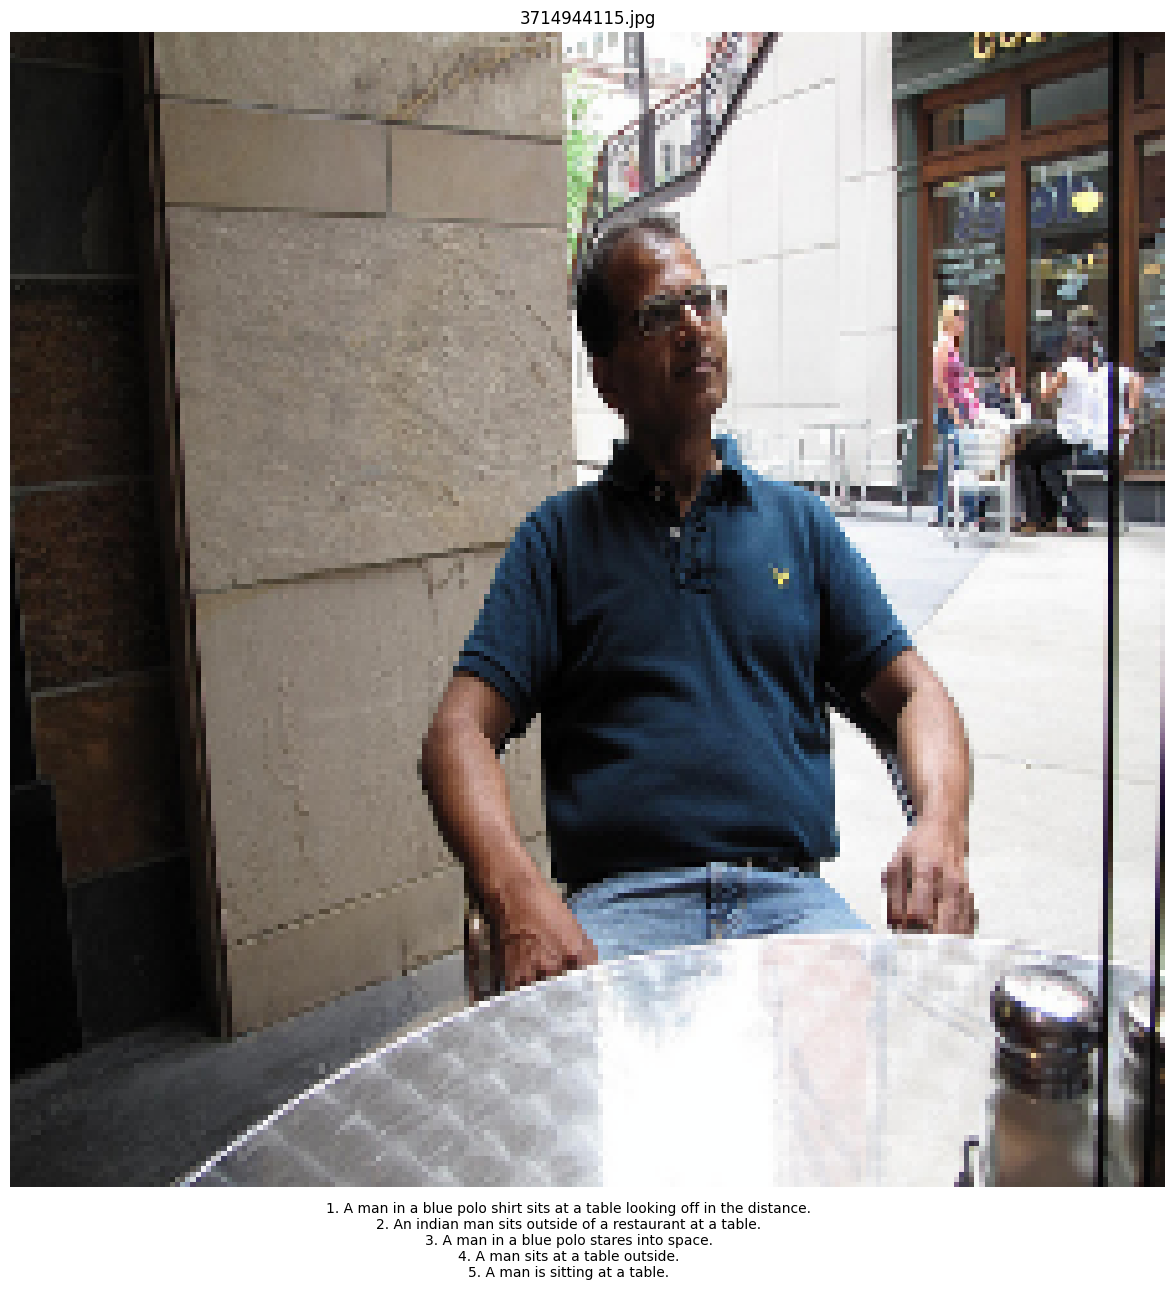

In [131]:
dataset.visualize_item() # Visualize one image at random from the dataset

## Model

Set the model configurations for the TERN transformer model.

In [132]:
d_embed = 1024                      # output_dim
d_model = 768                      # model dim
d_ff = 2048                          # feed-forward dim to be used in the transformers
aggregation = "mean"                # [mean, first]
N_v = 4                             # number of Vision Transformer encoder layers
N_l = 0                             # number of Text Transformer encoder layers
heads = 4                           # number of heads to be used in the visual and textual transformer
dropout = 0.1                       # dropout rate to be used in the transformer
precomp_bert = True                 # whether to use bert feature extractor
num_sw_layers = 0                   # number of shared-weight layers in the TERN architecture
max_rel_pos = 5                     # number of inputs to the left and right to be considered in the relative embedding matrix

### Architecture

Here I will build the TERN (Transformer Encoder Reasoning Network) Model Architecture, which I will training with the above DataLoader. But there is one key difference compared to the original TERN model architecture:
- I have incorporated the Relative Positional Encoding (RPE) instead of Sinusoidal Positional Encoding on both Image and Text side Transformers.

I could have used the already available layers in the `torch.nn` module. But incorporating the RPE requires modifying the way the Attention is calculated in the `MultiHeadAttention` so, I implemented the `MultiHeadAttention` to take into account the RPE.

In [133]:
class RelativePosition(nn.Module):
  """
  Calculate relative positional matrices
  :input:
    num_units:               relative positional embedding dimension
    max_relative_position:   number of inputs to the left and right of each input to consider for building the Relative Positional Embedding Matrix
  :output:
    relative positional embedding matrix
  """
  def __init__(self, num_units, max_relative_position):
    super().__init__()
    self.num_units = num_units # The relative positional embedding dimension
    self.max_relative_position = max_relative_position # The maximum number of inputs on either side to consider
    self.embeddings_table = nn.Parameter(torch.Tensor(max_relative_position * 2 + 1, num_units)) # The relative positional embedding matrix
    nn.init.xavier_uniform_(self.embeddings_table) # For initialization of the embeddings_table

  def forward(self, length_q, length_k):
    # length_q and length_k are nothing but just sequence length and is same in this case
    range_vec_q = torch.arange(length_q)
    range_vec_k = torch.arange(length_k)
    distance_mat = range_vec_k[None, :] - range_vec_q[:, None]
    # Clipped distance matrix where each row corresponds to the current input and it's entries refer to the inputs with which we consider the relative positional relationship -- Clipped as explained in the paper
    distance_mat_clipped = torch.clamp(distance_mat, -self.max_relative_position, self.max_relative_position)
    final_mat = distance_mat_clipped + self.max_relative_position
    final_mat = torch.LongTensor(final_mat).to(device)
    embeddings = self.embeddings_table[final_mat].to(device)
    
    return embeddings

class RelMultiHeadAttention(nn.Module):
  """
  Calculate relative multihead attention with num_heads and relative positional encoding
  :input:
    heads:          number of attention heads
    d_model:        embedding dim
    dropout:        dropout rate
  :output:
  """
  def __init__(self, heads, d_model, max_relative_position, dropout = 0.1):
    super().__init__()
    self.d_model = d_model
    assert d_model % heads == 0
    self.d_k = d_model // heads
    self.h = heads
    self.max_relative_position = max_relative_position # Number of inputs on either side to consider for relative positional embedding
    self.relative_position_k = RelativePosition(self.d_k, self.max_relative_position) # Relative Positional Embedding Keys Matrix
    self.relative_position_v = RelativePosition(self.d_k, self.max_relative_position) # Relative Positional Embedding Values Matrix
    self.q_linear = nn.Linear(d_model, d_model) # Queries Projection Matrix
    self.v_linear = nn.Linear(d_model, d_model) # Values Projection Matrix
    self.k_linear = nn.Linear(d_model, d_model) # Keys Projection Matrix
    self.dropout = nn.Dropout(dropout)
    self.out = nn.Linear(d_model, d_model)
    self.scale = torch.sqrt(torch.FloatTensor([self.d_k])).to(device) # The scaling factor for the scaled-dot product attention

  def forward(self, q, k, v, mask = None):

    k = k.to(device) # key = [batch size, key len, hid dim]
    q = q.to(device) # query = [batch size, query len, hid dim]
    v = v.to(device) # value = [batch size, value len, hid dim]
    bs = q.size(0) # batch size
    len_k = k.shape[1] # sequence length 
    len_q = q.shape[1] # sequence length
    len_v = v.shape[1] # sequence length
    k = self.k_linear(k) # Linearly Projecting the Keys Matrix
    q = self.q_linear(q) # Linearly Projecting the Queries Matrix
    v = self.v_linear(v) # Linearly Projecting the Values Matrix

    # Usual Compatibility Function Calculation
    q1 = q.view(bs, -1, self.h, self.d_k).permute(0, 2, 1, 3)
    k1 = k.view(bs, -1, self.h, self.d_k).permute(0, 2, 1, 3)
    attn1 = torch.matmul(q1, k1.permute(0, 1, 3, 2))

    # Relative Positional Encoding Compatibility Function additional term calculate
    r_k = self.relative_position_k(len_q, len_k)
    r_k = r_k.permute(0, 2, 1)
    q2 = q1.permute(2, 0, 1, 3).reshape(len_q, -1, self.d_k)

    attn2 = torch.matmul(q2, r_k).view(len_q, bs, self.h, len_q)
    attn2 = attn2.permute(1, 2, 0, 3)
    attn = (attn1 + attn2) / self.scale # Final Compatibility Function

    if mask is not None:
      attn = attn.masked_fill(mask == 0, -1e10)

    attn = self.dropout(torch.softmax(attn, dim = -1)) # attn = [batch size, n heads, query len, key len]
    
    v1 = v.view(bs, -1, self.h, self.d_k).permute(0, 2, 1, 3) 
    weight1 = torch.matmul(attn, v1) # Usual attn-weighted value sum

    # Relative Positional Encoding attn-weighted values for additional term calculate
    r_v = self.relative_position_v(len_q, len_v)
    weight2 = attn.permute(2, 0, 1, 3).contiguous().view(len_q, bs*self.h, len_k)
    weight2 = torch.matmul(weight2, r_v)
    weight2 = weight2.transpose(0, 1).contiguous().view(bs, self.h, len_q, self.d_k)
    
    x = weight1 + weight2 # x = [batch size, n heads, query len, head dim]
    x = x.permute(0, 2, 1, 3).contiguous() # x = [batch size, query len, n heads, head dim]
    x = x.view(bs, -1, self.d_model) # x = [batch size, query len, hid dim]
    x = self.out(x) # x = [batch size, query len, hid dim]

    return x
  
def attention(q, k, v, d_k, mask=None, dropout=None):
  """
  Calculate attention
  :input:
      q:          query
      k:          key
      v:          value
      d_k:        scaled term
      mask:       whether to use masking attention
      dropout:    dropout rate
  :output:
  """

  # Query, Key matrix multiplication
  scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)

  # If mask, use masking attetion
  if mask is not None:
    mask = mask.unsqueeze(1)
    scores = scores.masked_fill(mask == 0, -1e9)

  # Softmax for scaling in range [0,1]
  scores = F.softmax(scores, dim=-1)

  # Dropout
  if dropout is not None:
    scores = dropout(scores)

  # Score, Value matrix multiplication
  output = torch.matmul(scores, v)
  return output, scores

class MultiHeadAttention(nn.Module):
  """
  Calculate multihead attention with num_heads
  :input:
      heads:          number of attention heads
      d_model:        embedding dim
      dropout:        dropout rate
  :output:
  """
  def __init__(self, heads, d_model, max_relative_position, dropout = 0.1):
    super().__init__()

    self.d_model = d_model
    self.d_k = d_model // heads
    self.h = heads

    self.q_linear = nn.Linear(d_model, d_model)
    self.v_linear = nn.Linear(d_model, d_model)
    self.k_linear = nn.Linear(d_model, d_model)

    self.dropout = nn.Dropout(dropout)
    self.out = nn.Linear(d_model, d_model)

    # For visualization
    self.attn = None

  def forward(self, q, k, v, mask=None):

    bs = q.size(0)

    # perform linear operation and split into N heads
    k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
    q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
    v = self.v_linear(v).view(bs, -1, self.h, self.d_k)

    # transpose to get dimensions bs * N * sl * d_model
    k = k.transpose(1,2)
    q = q.transpose(1,2)
    v = v.transpose(1,2)


    # calculate attention 
    scores, self.attn = attention(q, k, v, self.d_k, mask, self.dropout)
    # concatenate heads and put through final linear layer
    concat = scores.transpose(1,2).contiguous()\
    .view(bs, -1, self.d_model)
    output = self.out(concat)

    return output

Now, after the RPE-Based `MultiHeadAttention` I will build the usual Transformer Architecture.

Following are the `PositionwiseFeedForword` Layer and `LayerNorm` which is used in the `EncoderLayer`s of the Transformer's Encoder.

In [134]:
class PositionwiseFeedForward(nn.Module):
  """
  Just a simple 2-layer feed forward, input and output shape are equal
  """
  def __init__(self, model_dim, ff_dim, dropout=0.1):
    super().__init__()
    self.w_1 = nn.Linear(model_dim, ff_dim)
    self.w_2 = nn.Linear(ff_dim, model_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    """
    Apply RELU and dropout between two layers
    """
    return self.w_2(self.dropout(F.gelu(self.w_1(x))))

class LayerNorm(nn.Module):
  "Construct a layernorm module."
  def __init__(self, model_dim, eps=1e-6):
    super().__init__()
    self.a_2 = nn.Parameter(torch.ones(model_dim))
    self.b_2 = nn.Parameter(torch.zeros(model_dim))
    self.eps = eps

  def forward(self, x):
    mean = x.mean(-1, keepdim=True)
    std = x.std(-1, keepdim=True)
    return self.a_2 * (x - mean) / (std + self.eps) + self.b_2    
  
class RelEncoderLayer(nn.Module):
  """
  Single encoder layer consists of Relative Multihead Attention, 
  2-layer feed forward, Layer Normalization and Dropout
  """
  def __init__(self, d_model, d_ff, heads, max_rel_pos, dropout=0.1):
    super().__init__()
    self.norm_1 = LayerNorm(d_model)
    self.norm_2 = LayerNorm(d_model)
    self.attn = RelMultiHeadAttention(heads, d_model, max_rel_pos, dropout=dropout)
    self.ff = PositionwiseFeedForward(d_model, d_ff, dropout=dropout)
    self.dropout_1 = nn.Dropout(dropout)
    self.dropout_2 = nn.Dropout(dropout)

  def forward(self, x, mask):
    x2 = self.norm_1(x)
    x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
    x2 = self.norm_2(x)
    x = x + self.dropout_2(self.ff(x2))
    return x
  
class EncoderLayer(nn.Module):
  """
  Single encoder layer consists of Multihead Attention, 
  2-layer feed forward, Layer Normalization and Dropout
  """
  def __init__(self, d_model, d_ff, heads, max_rel_pos, dropout=0.1):
    super().__init__()
    self.norm_1 = LayerNorm(d_model)
    self.norm_2 = LayerNorm(d_model)
    self.attn = MultiHeadAttention(heads, d_model, max_rel_pos, dropout=dropout)
    self.ff = PositionwiseFeedForward(d_model, d_ff, dropout=dropout)
    self.dropout_1 = nn.Dropout(dropout)
    self.dropout_2 = nn.Dropout(dropout)

  def forward(self, x, mask):
    x2 = self.norm_1(x)
    x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
    x2 = self.norm_2(x)
    x = x + self.dropout_2(self.ff(x2))
    return x

The following are few utility functions for creating the `TransformerEncoder`, Vision and Text Transformers and deals with intialization, making identical layers and $L_2$-normalizing vectors.

In [135]:
def get_clones(module, N):
  """
  "Produce N identical layers."
  """
  return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

def init_xavier(model):
  for p in model.parameters():
    if p.dim() > 1:
      nn.init.xavier_uniform_(p)

def l2norm(X):
  """
  L2-normalize columns of X
  """
  norm = torch.pow(X, 2).sum(dim=1, keepdim=True).sqrt()
  X = torch.div(X, norm)
  return X

Stacking multiple `EncoderLayer`s to build the `TransformerEncoder`, which will be used near the end of the `TERN` architecture and will serve as shared weight transformer for visual and textual feature outputs by the respective ViT and Language Transformer.

`ModalProjection` projects the output vector of `in_dim` of Vision Transformer and Language Transformer for each modal to `out_dim` after passing it through an `ReLU` activation. This is used as the final step to come up with two vector outputs one for visual side and other for textual side.

In [136]:
class TransformerEncoder(nn.Module):
  """
  transformer encoder
  """
  def __init__(self, d_model, d_ff, N, heads, max_rel_pos, dropout, sw = False):
    super().__init__()
    self.N = N
    self.sw = sw
  
    if self.N >= 1 and (not self.sw):
      self.rel_layer = RelEncoderLayer(d_model, d_ff, heads, max_rel_pos, dropout)
    if self.N > 1:
      self.layers = get_clones(EncoderLayer(d_model, d_ff, heads, max_rel_pos, dropout), N-1)
      self.norm = LayerNorm(d_model)  

  def forward(self, x):
    if self.N >= 1 and (not self.sw):
      x = self.rel_layer(x, mask=None)
    if self.N > 1:
      for i in range(self.N-1):
        x = self.layers[i](x, mask=None)
      x = self.norm(x)
    return x

class ModalProjection(nn.Module):
  """
  Project features into same space
  """
  def __init__(self, in_dim, out_dim):
    super().__init__()

    self.model = nn.Sequential(
          nn.Linear(in_dim, in_dim),
          nn.ReLU(),
          nn.Linear(in_dim, out_dim))

  def forward(self, x):
    return self.model(x)

Now, we will build at the Vision Transformer Encoder `EncoderBottomUp`. But for that I will embed the visual features (extracted by ResNet) of each region to be transformed to `embed_dim` from `features_dim`, which is done by `FeatureEmbedding` and `SpatialEncoding` transforms the bounding box coordinates to `embed_dim` to be added to the visual features.

In [137]:
class FeatureEmbedding(nn.Module):
  """
  Projects image features into a space of
  dimensionality `embed_dim`.
  """
  def __init__(self, features_dim, embed_dim):
    super().__init__()
    self.linear = nn.Linear(features_dim, embed_dim)

  def forward(self, x):
    return self.linear(x)


class SpatialEncoding(nn.Module):
  """
  Encodes bounding box coordinates and relative sizes
  as vector of dimensionality `embed_dim`.
  """
  def __init__(self, embed_dim):
    super().__init__()
    self.linear = nn.Linear(5, embed_dim)

  def forward(self, x):
    return self.linear(x)

The following is the `EncoderBottomUp` layer that will add the `cls_token1` before the sequence of region's feature embedding and `cls_token2` before the sequence of region's location feature embedding. After that it will apply the `FeatureEmbedding` and `SpatialEncoding` layer to come with a single sequence of feature instead of two, by adding the location features and the regions extracted features.

In [138]:
class EncoderBottomUp(nn.Module):
  """
  Encoder for Bottom-Up-Attention features
  :input:
      feat_dim:       feature dim
      d_model:        embeddings dim
  :output:
      encoded embeddings shape [batch * input length * model_dim]
  """
  def __init__(self, feat_dim, d_model):
    super().__init__()
    self.cls_token1 = nn.Parameter(torch.zeros(1, 1, d_model)) # Add CLS token 
    self.cls_token2 = nn.Parameter(torch.zeros(1, 1, d_model)) # Add CLS token 

    self.feat_embed = FeatureEmbedding(feat_dim, d_model)
    self.loc_embed = SpatialEncoding(d_model)

  def forward(self, src, spatial_src):
    x = self.feat_embed(src)
    cls_token1 = self.cls_token1.expand(x.shape[0], -1, -1)
    x = torch.cat((cls_token1, x), dim=1)

    spatial_x = self.loc_embed(spatial_src)
    cls_token2 = self.cls_token2.expand(spatial_x.shape[0], -1, -1)
    spatial_x = torch.cat((cls_token2, spatial_x), dim=1)

    x += spatial_x

    return x

Now, I will construct the `EncoderBERT` layer that applies the `distilbert-base-uncased` pretrained model to convert the input to extracted features. But, since I have precomputed the features on the captions, the `precomp` argument is set to `True` and `EncoderBERT` won't compute these features for the captions again and simply pass the `x` tensor when it is called with it, when `precomp = True`.

In [139]:
class EncoderBERT(nn.Module):
  """
  Pretrained BERT model
  :input:
      version:       bert version
      precomp:       True, if precomputed features is to be used
  :output:
      encoded embeddings shape [batch * input length * model_dim]
  """

  def __init__(self, feat_dim, d_model, version='distilbert-base-uncased', precomp=True, device=None):
    super().__init__()
  
    self.feat_dim = feat_dim
    self.d_model = d_model
    self.feat_embed = FeatureEmbedding(feat_dim, d_model)
    
    self.precomp = precomp

    if not self.precomp:
      model = AutoModel.from_pretrained(version)

      tokenizer = AutoTokenizer.from_pretrained(version, add_special_tokens = 'true', padding = 'longest')

      self.pipeline = pipeline(
        'feature-extraction', 
        model=model, 
        tokenizer=tokenizer, 
        device = 0 if device is not None else -1)

  def forward(self, x):
    if not self.precomp:
      with torch.no_grad():
        x = self.pipeline(x)
      x = np.squeeze(x)
      if len(x.shape) == 2:
        x = np.expand_dims(x, axis=0)
      x = make_feature_batch(x, pad_token=0)
      x = x.to(device)
    x = self.feat_embed(x)

    return x

Finally, we put it all together into the `TERN` Model.

In [140]:
class TERN(nn.Module):
  """
  Architecture idea based on Transformer Encoder Reasoning Network
  :input:
    d_model: Embedding Dimension for the Visual and Textual Encoder
    d_ff: FeedForward Network Hidden Unit in Visual and Textual Encoder
    N_v: Number of Encoder Layers in Visual Encoder
    N_l: Number of Encoder Layers in Language Encoder
    heads: Number of heads in Visual and Textual Encoder
    max_rel_pos: Number of inputs on either side of an input to be considered for Relative Position Encoding
    dropout: Dropout Rate
    aggregation: After Visual and Textual Encoder, how to collapse the temporal dimension of the output
    precomp_bert: True/False depending on if you have pre-computed features
    num_sw_layers: Number of shared transformer encoder layers
  :output:
    visual output feature vector, language output feature vector
  """
  def __init__(self, d_model, d_embed, d_ff, N_v, N_l, heads, max_rel_pos, dropout, aggregation, precomp_bert, num_sw_layers, **kwargs):
    super(TERN, self).__init__()
    self.name = "TERN" # Name of the model
    self.aggregation = aggregation # ['mean' | 'first'] How to collapse the Transformer Sequence output into a single feature vector
    self.precomp_bert = precomp_bert # If the BERT features need to be computed?

    self.encoder_v = EncoderBottomUp(feat_dim=2048, d_model=d_model) # Visual Embedding Layer [Considering the combined output of Faster-RCNN and Resnet extracted features to be the embedding for the visual transformer model]
    self.encoder_l = EncoderBERT(feat_dim=768, d_model=d_model, precomp=precomp_bert) # Textual Embedding Layer [Considering the output of BERT to be the embedding for the textual transformer model]

    self.reasoning_v = TransformerEncoder(d_model=d_model, d_ff=d_ff, N=N_v, heads=heads, max_rel_pos=max_rel_pos, dropout=dropout) # ViT
    self.reasoning_l = TransformerEncoder(d_model=d_model, d_ff=d_ff, N=N_l, heads=heads, max_rel_pos=max_rel_pos, dropout=dropout) # LangT
  
    if num_sw_layers > 0: # Shared weight encoders
      self.sw_layer = TransformerEncoder(d_model=d_model, d_ff=d_ff, N=num_sw_layers, heads=heads, max_rel_pos=max_rel_pos, dropout=dropout, sw=True)
    else:
      self.sw_layer = None
    
    self.img_proj = ModalProjection(in_dim=d_model, out_dim=d_embed) # Final projection of in_dim vector to out_dim vector for visual side
    self.cap_proj = ModalProjection(in_dim=d_model, out_dim=d_embed) # Final projection of in_dim vector to out_dim vector for textual side

    init_xavier(self)

  def forward(self, batch):
    outputs_v = self.visual_forward(batch)
    outputs_l = self.lang_forward(batch)
    return outputs_l, outputs_v


  def visual_forward(self, batch):
    visual_inputs = batch['feats'].to(device)
    spatial_inputs = batch['loc_feats'].to(device)

    outputs_v = self.encoder_v(visual_inputs, spatial_inputs) 
    outputs_v = self.reasoning_v(outputs_v)                   

    if self.sw_layer is not None:
      outputs_v = self.sw_layer(outputs_v)

    if self.aggregation == 'mean':
      feats_v = self.img_proj(outputs_v).mean(dim=1)
    if self.aggregation == 'first':
      feats_v = self.img_proj(outputs_v)[:, 0]

    feats_v = l2norm(feats_v)
    return feats_v

  def lang_forward(self, batch):
    if self.precomp_bert:
      lang_inputs = batch['lang_feats'].to(device)
      outputs_l = self.encoder_l(lang_inputs) 
    else:
      outputs_l = self.encoder_l(batch['texts'])
      outputs_l = outputs_l.to(device)

    outputs_l = self.reasoning_l(outputs_l)

    if self.sw_layer is not None:
      outputs_l = self.sw_layer(outputs_l)

    if self.aggregation == 'mean':
      feats_l = self.cap_proj(outputs_l).mean(dim=1)

    if self.aggregation == 'first':
      feats_l = self.cap_proj(outputs_l)[:, 0]

    feats_l = l2norm(feats_l)
    return feats_l

In [141]:
tern = TERN(
  d_model=d_model,
  d_embed=d_embed,
  d_ff=d_ff,
  N_v=N_v,
  N_l=N_l,
  heads=heads,
  max_rel_pos=max_rel_pos,
  dropout=dropout,
  aggregation='mean',
  precomp_bert=True,
  num_sw_layers=num_sw_layers
).to(device)

In [142]:
tern.parameters

<bound method Module.parameters of TERN(
  (encoder_v): EncoderBottomUp(
    (feat_embed): FeatureEmbedding(
      (linear): Linear(in_features=2048, out_features=768, bias=True)
    )
    (loc_embed): SpatialEncoding(
      (linear): Linear(in_features=5, out_features=768, bias=True)
    )
  )
  (encoder_l): EncoderBERT(
    (feat_embed): FeatureEmbedding(
      (linear): Linear(in_features=768, out_features=768, bias=True)
    )
  )
  (reasoning_v): TransformerEncoder(
    (rel_layer): RelEncoderLayer(
      (norm_1): LayerNorm()
      (norm_2): LayerNorm()
      (attn): RelMultiHeadAttention(
        (relative_position_k): RelativePosition()
        (relative_position_v): RelativePosition()
        (q_linear): Linear(in_features=768, out_features=768, bias=True)
        (v_linear): Linear(in_features=768, out_features=768, bias=True)
        (k_linear): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (out): Linear(in_feat

### Loss Function

Since, the objective is to learn good vector representation of the textual and image features in the joint-embedding space. The task is to maximize the similarity between the vector representation of the caption and the vector representation of the corresponding image.

This idea is similar to that of Siamese Network, where we train triplet loss function to maximize the similarity between the same input images but increases the dissimilarity between the different input images. Here, the difference is instead of having pairs of images we have pairs of image and texts.

Thus, `ContrastiveLoss` is chosen as the loss function.

In [143]:
class ContrastiveLoss(nn.Module):
    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)
        self.loss_fn = losses.ContrastiveLoss(**kwargs)

    def forward(self, feats1, feats2):
        labels = torch.arange(feats1.size(0))
        embeddings = torch.cat([feats1, feats2], dim=0)
        labels = torch.cat([labels, labels], dim=0)

        loss = self.loss_fn(embeddings, labels)
        return {'T': loss}

In [144]:
criterion = ContrastiveLoss()

### Evalutation Metric

The reason why I am creating the evaluation metric before training is while training, there will be a evaluation step on the validation dataset. Thus, to carry out that step to get an idea about validation loss. I create the evaluation metrics before training.

I will be using the following metrics for evaluation:
- F1
- MAP (Mean Average Precision)
- NN (Nearest Neighbor)
- Recall
- First Tier
- Second Tier

In [145]:
class F1Metric:
  """
  F1 score at K
  """
  def __init__(self, k, decimals = 4):
    self.k = k
    self.decimals = decimals
    self.scores = []

  def compute(self):
    mean_score = np.mean(self.scores)
    mean_score = np.round(float(mean_score), decimals=self.decimals)
    return mean_score

  def update(self, output, target):
    output = output[:self.k]
    n = len(np.intersect1d(target,output)) # Number of corrects
    score = 2*n / (len(target)+len(output))
    self.scores.append(score)

  def reset(self):
    self.scores = []

  def value(self):
    score = self.compute()
    return {f"F1@{self.k}" : score}

  def __str__(self):
    return f'{self.value()}'

  def __len__(self):
    return len(self.scores)

In [146]:
class MAPMetric:
  """
  Mean average precision at K
  """
  def __init__(self, k, decimals = 4):
    self.k = k
    self.decimals = decimals
    self.scores = []

  def compute(self):
    mean_score = np.mean(self.scores)
    mean_score = np.round(float(mean_score), decimals=self.decimals)
    return mean_score

  def update(self, output, target):
    output = output[:self.k]
    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(output):
      if p in target and p not in output[:i]:
        num_hits += 1.0
        score += num_hits / (i+1.0)
    self.scores.append(score)

  def reset(self):
    self.scores = []

  def value(self):
    score = self.compute()
    return {f"MAP@{self.k}" : score}

  def __str__(self):
    return f'{self.value()}'

  def __len__(self):
    return len(self.scores)

In [147]:
class NearestNeighborMetric:
  """
  Nearest neighbor
  """
  def __init__(self, decimals = 4):
    self.decimals = decimals
    self.scores = []

  def compute(self):
    mean_score = np.mean(self.scores)
    mean_score = np.round(float(mean_score), decimals=self.decimals)
    return mean_score

  def update(self, output, target):
    score = int(output[0] in target)
    self.scores.append(score)

  def reset(self):
    self.scores = []

  def value(self):
    score = self.compute()
    return {"NN" : score}

  def __str__(self):
    return f'{self.value()}'

  def __len__(self):
    return len(self.scores)

In [148]:
class RecallMetric:
  """
  Nearest neighbor
  """
  def __init__(self, k, decimals = 4):
    self.k = k
    self.decimals = decimals
    self.scores = []

  def compute(self):
    mean_score = np.mean(self.scores)
    mean_score = np.round(float(mean_score), decimals=self.decimals)
    return mean_score

  def update(self, output, target):
    retrieved_labels = output[:self.k]
    n_targets = len(target)                                        # Number of targets
    n_relevant_objs = len(np.intersect1d(target,retrieved_labels)) # Number of corrects
    score = n_relevant_objs*1.0 / n_targets
    self.scores.append(score)

  def reset(self):
    self.scores = []

  def value(self):
    score = self.compute()
    return {f"R@{self.k}" : score}

  def __str__(self):
    return f'{self.value()}'

  def __len__(self):
    return len(self.scores)

In [149]:
class FirstTierMetric:
  """
  First Tier
  """
  def __init__(self, decimals = 4):
    self.decimals = decimals
    self.scores = []

  def compute(self):
    mean_score = np.mean(self.scores)
    mean_score = np.round(float(mean_score), decimals=self.decimals)
    return mean_score

  def update(self, output, target):
    n_relevant_objs = sum([1 if i in target else 0 for i in output])
    retrieved_1st_tier = output[:n_relevant_objs+1]
    score = np.mean([1 if i in target else 0 for i in retrieved_1st_tier])
    self.scores.append(score)

  def reset(self):
    self.scores = []

  def value(self):
    score = self.compute()
    return {"FT" : score}

  def __str__(self):
    return f'{self.value()}'

  def __len__(self):
    return len(self.scores)

In [150]:
class SecondTierMetric:
  """
  Second Tier
  """
  def __init__(self, decimals = 4):
    self.decimals = decimals
    self.scores = []

  def compute(self):
    mean_score = np.mean(self.scores)
    mean_score = np.round(float(mean_score), decimals=self.decimals)
    return mean_score

  def update(self, output, target):
    n_relevant_objs = sum([1 if i in target else 0 for i in output])
    retrieved_2nd_tier = output[:2*n_relevant_objs+1]
    score = np.mean([1 if i in target else 0 for i in retrieved_2nd_tier])
    self.scores.append(score)

  def reset(self):
    self.scores = []

  def value(self):
    score = self.compute()
    return {"ST" : score}

  def __str__(self):
    return f'{self.value()}'

  def __len__(self):
    return len(self.scores)

Based on all the above metrics, I define a single `RetrievalScore` class that will load the evaluation dataloaders on instantiation and will help us readily evaluate the model

In [151]:
# Some utility functions
def get_dist_func(name):
  if name == 'cosine':
    return cosine_distances # 1 - similarity
  elif name == 'euclide':
    return euclidean_distances
  else:
    raise NotImplementedError

def save_results(query_results, outname):
  if not os.path.exists('./results/'):
    os.mkdir('./results/')
  np.save(f'./results/{outname}.npy', query_results, allow_pickle=True)

def get_top_k(object_dist_score, top_k=5, max_distance=2.0):
  """
  Input: Array of distance of each item in the gallery to the query
  Return: top k objects's indexes and scores
  """
  top_k_indexes = object_dist_score.argsort()[:top_k] # Sort item by distance and get top-k
  top_k_scores = object_dist_score[top_k_indexes]

  if max_distance is not None: # Keep only item with near distance
    keep_indexes = top_k_scores <= max_distance
    top_k_indexes = top_k_indexes[keep_indexes]
    top_k_scores = top_k_scores[keep_indexes]

  return top_k_indexes, top_k_scores

metrics_mapping = { # All the metrics to keep track of during evaluation
  'FT': FirstTierMetric(),
  'ST': SecondTierMetric(),
  'NN': NearestNeighborMetric(),
  'MAP@10': MAPMetric(k=10),
  'F1@10': F1Metric(k=10),
  'R@1': RecallMetric(k=1),
  'R@5': RecallMetric(k=5),
  'R@10': RecallMetric(k=10),
}

The `RetrievalScore` calculates the value of each of the above metric when called.
It saves the prediction for each batch:
- `./results/i2t_results.npy` for image-to-text retrieval
- `./results/t2i_results.npy` for text-to-image retrieval.

Set `eval_batch_size` for the evaluation batch size.

In [152]:
eval_batch_size = 128 # Set the evaluation batch size
eval_num_workers = 0

In [153]:
class RetrievalScore:    
  def __init__(self, 
        image_set, 
        text_set, 
        dimension=1024,
        metric_names=['FT', "ST", "MAP@10", "NN", "F1@10", "R@10"],
        max_distance = None,
        top_k=10,
        save_results=True):

    self.metric_names = metric_names
    self.image_loader = data.DataLoader(
      image_set,
      batch_size=eval_batch_size,
      shuffle = False, 
      collate_fn=image_set.collate_fn, 
      num_workers= eval_num_workers,
      pin_memory=True
    )

    self.text_loader = data.DataLoader(
      text_set,
      batch_size=eval_batch_size,
      shuffle = False, 
      collate_fn=text_set.collate_fn, 
      num_workers= eval_num_workers,
      pin_memory=True
    )

    self.top_k = top_k                  # Query top k candidates
    self.max_distance = max_distance    # Query candidates with distances lower than threshold
    self.save_results = save_results    # Save for vizualization

    self.image_embedding = [] 
    self.text_embedding = []

    # For image-to-text retrieval
    self.image_ids = []
    self.text_target_ids = []

    # For text-to-image retrieval
    self.text_ids = []
    self.image_target_ids = []

    if self.save_results:
      self.results_dict = {}

    self.dist_func = get_dist_func('cosine') # Distance function

  def reset(self):
    self.image_embedding = [] 
    self.text_embedding = []

    # For image-to-text retrieval
    self.image_ids = []
    self.text_target_ids = []

    # For text-to-image retrieval
    self.text_ids = []
    self.image_target_ids = []

    if self.save_results:
      self.results_dict = {}

    for metric_name in self.metric_names:
      metric_fn = metrics_mapping[metric_name]
      metric_fn.reset()        

  def update(self, model):
    self.model = model
    self.model.model.eval()

  def compute_images(self):
    for idx, batch in enumerate(tqdm(self.image_loader)):
      image_ids = batch['ids']
      text_target_ids = batch['text_ids']
      feats = self.model.get_visual_embeddings(batch)

      # Get embedding of each item in batch
      batch_size = feats.shape[0]
      for i in range(batch_size):
        feat = feats[i]
        self.image_embedding.append(feat)
        self.image_ids.append(image_ids[i])
        self.text_target_ids.append(text_target_ids[i])

    self.image_embedding = np.array(self.image_embedding)
    self.text_target_ids = np.array(self.text_target_ids)
    self.image_ids = np.array(self.image_ids)

  def compute_texts(self):
    for idx, batch in enumerate(tqdm(self.text_loader)):
      text_ids = batch['ids']
      image_target_ids = batch['image_ids']
      feats = self.model.get_lang_embeddings(batch)

      # Get embedding of each item in batch
      batch_size = feats.shape[0]
      for i in range(batch_size):
        feat = feats[i]
        self.text_embedding.append(feat)
        self.text_ids.append(text_ids[i])
        self.image_target_ids.append(image_target_ids[i])

    self.text_embedding = np.array(self.text_embedding)
    self.image_target_ids = np.array(self.image_target_ids)
    self.text_ids = np.array(self.text_ids)

  def compute_default(self, queries_embedding, gallery_embedding, queries_ids, targets_ids, gallery_ids):
    """
    Compute score for each metric and return 
    """

    # Compute distance matrice for queries and gallery
    print("Calculating distance matrice...")
    dist_mat = self.dist_func(queries_embedding, gallery_embedding)

    # np.savetxt("./results/dist_mat.txt",dist_mat)
    for idx, row in enumerate(dist_mat):
      object_dist_score = dist_mat[idx]
      top_k_indexes, top_k_scores = get_top_k(
        object_dist_score,
        top_k=self.top_k,
        max_distance=self.max_distance
      )

      current_id = queries_ids[idx] # query id
      target_ids = targets_ids[idx] if not isinstance(targets_ids[idx], np.int64) else np.array([targets_ids[idx]]) # target id 

      pred_ids = gallery_ids[top_k_indexes] # gallery id
      pred_ids = pred_ids.tolist() if not isinstance(pred_ids.tolist(), int) else [pred_ids.tolist()]

      if self.save_results:
          self.results_dict[current_id] = {
            'pred_ids': pred_ids,
            'target_ids': target_ids,
            'scores': top_k_scores 
          }

      for metric_name in self.metric_names:
        metric_fn = metrics_mapping[metric_name]
        metric_fn.update(pred_ids, target_ids)

  def _compute_score(
    self, 
    queries_embedding, 
    gallery_embedding, 
    queries_ids, 
    targets_ids, 
    gallery_ids,
    outname):

    self.results_dict = {}

    self.compute_default(
      queries_embedding, 
      gallery_embedding, 
      queries_ids, 
      targets_ids, 
      gallery_ids)

    # Save results for visualization later
    if self.save_results:
      print("Saving retrieval results...")
      save_results(self.results_dict, outname)

    result_dict = {}
    for metric_name in self.metric_names:
      metric_fn = metrics_mapping[metric_name]
      result_dict.update(metric_fn.value())

    return result_dict

  def compute(self):
    print("Extracting features...")
    self.reset()
    with torch.no_grad():
      self.compute_images()
      self.compute_texts()

    i2t_dict = self._compute_score(
      self.image_embedding, self.text_embedding, 
      self.image_ids, self.text_target_ids, self.text_ids, outname='i2t_results')

    t2i_dict = self._compute_score(
      self.text_embedding, self.image_embedding, 
      self.text_ids , self.image_target_ids, self.image_ids, outname='t2i_results')

    result_dict = {"i2t/" + k : v for k,v in i2t_dict.items()}
    result_dict.update({"t2i/" + k : v for k,v in t2i_dict.items()})

    return result_dict

  def value(self):
    result_dict = self.compute()
    return result_dict

  def __str__(self):
    return str(self.value())

In [154]:
top_k = 10 # How many top k elements to select when computing distance/similary based metrics above?
max_distance = 2.0 # Within how much distance should I consider the top_k elements?
metric_names = ["R@1", "R@5", "R@10"] # Metrics to compute select from FT, ST, NN, MAP@10, F1@10, R@1, R@5, R@10

In [155]:
metric = RetrievalScore( # Instantiation metric class
          valset1, valset2, 
          max_distance = max_distance,
          top_k=top_k,
          metric_names=metric_names,
          dimension=d_embed,
          save_results=True)

### Optimizer

I choose to go with the `AdamW` optimizer. The optimizer parameters can be set by changing the following values.

In [156]:
lr = 1e-5 # Learning Rate
betas = (0.937, 0.98) # Momentum Term
eps = 1e-9 # Epsilon
weight_decay = 0.0005 # Weight Decay

In [157]:
optimizer = torch.optim.AdamW(tern.parameters(), lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

The `CosineAnnealingWithRestarts` is used as the learning rate annealing function.

In [158]:
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 5)

### Training

I define a model class `Retriver` that will make handling of the `tern` model easier in terms:
- evaluation (`evaluate_step`)
- training (`training_step`)
- inference (`inference_step`)
- extracting feature (`get_visual_embeddings`, `get_lang_embeddings`)

In [159]:
class Retriever:
  def __init__(self, model, optimizer, criterion, metrics, freeze=False): # scheduler,
    super().__init__()
    self.model = model
    self.model_name = self.model.name
    self.optimizer = optimizer
    # self.scheduler = scheduler
    self.criterion = criterion
    self.freeze = freeze
    self.metrics = metrics # Metrics to evaluate the model on
    if not isinstance(metrics, list):
      self.metrics = [metrics,]
    if self.freeze: # Freezing the model parameters
      for params in self.model.parameters():
          params.requires_grad = False

  def forward(self, x):
    return self.model(x)

  def training_step(self, batch):
    outputs_1, outputs_2 = self.model(batch)
    loss = self.criterion(outputs_1, outputs_2)
    return loss

  def inference_step(self, batch):
    outputs_1, outputs_2 = self.model(batch)
    return outputs_1.cpu().detach().numpy(), outputs_2.cpu().detach().numpy()

  def evaluate_step(self, batch):
    outputs_1, outputs_2 = self.model(batch)
    loss = self.criterion(outputs_1, outputs_2)
    self.update_metrics(model=self)
    return loss

  def get_visual_embeddings(self, batch): # Get Visual features for a batch
    outputs_v = self.model.visual_forward(batch)
    return outputs_v.cpu().detach().numpy().astype(np.float32)

  def get_lang_embeddings(self, batch): # Get Language features for a batch
    outputs_l = self.model.lang_forward(batch)
    return outputs_l.cpu().detach().numpy().astype(np.float32)
  
  def trainable_parameters(self):
    return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

  def unfreeze(self):
    for params in self.parameters():
      params.requires_grad = True

  def update_metrics(self, **kwargs):
    for metric in self.metrics:
      metric.update(**kwargs)

  def get_metric_values(self):
    metric_dict = {}
    for metric in self.metrics:
      metric_dict.update(metric.value())
    return metric_dict

  def reset_metrics(self):
    for metric in self.metrics:
      metric.reset()

In [160]:
model = Retriever( # Instantiating the model
  model=tern,
  optimizer=optimizer,
  criterion=criterion,
  metrics=metric
)
# scheduler=scheduler,

#### Checkpoint

The following `Checkpoint` class helps in saving the following things while training:
- `model`: model weights
- `optimizer`: optimizer state
- `epoch`: number of epochs trained for
- `iters`: number of iterations trained for

In [161]:
class Checkpoint():
  """
  Checkpoint for saving model state
  :param save_per_epoch: (int)
  :param path: (string)
  """
  def __init__(self, save_per_epoch = 2, path = None):
    self.path = path
    self.save_per_epoch = save_per_epoch
    # Create folder
    if self.path is None:
      self.path = os.path.join('weights',datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

  def save(self, model, epoch, iters, save_mode='last'):
    """
    Save model and optimizer weights
    :param model: Pytorch model with state dict
    """
    if not os.path.exists(self.path):
        os.makedirs(self.path)

    model_path = "_".join([model.model_name,save_mode])

    epoch = epoch
    iters = iters

    weights = {
      'model': model.model.state_dict(),
      'optimizer': model.optimizer.state_dict(),
      'epoch': epoch,
      'iters': iters,
    }

    torch.save(weights, os.path.join(self.path,model_path)+".pth")

Loading the model's and optimizer's `state_dict` for the `tern` model can be done using the following `load_checkpoint`.

In [162]:
def load_checkpoint(model, path):
  """
  Load trained model checkpoint
  :param model: (nn.Module)
  :param path: (string) checkpoint path
  """
  state = torch.load(path, map_location=device)
  model.load_state_dict(state["model"])
  if optimizer is not None:
    optimizer.load_state_dict(state["optimizer"])
  else:
    print('Failed to load optimizer state')
  print("Loaded Successfully!")
  print('Epochs Trained:', state["epoch"])
  print('Iterations Trained:', state["iters"])

#### Training

Now, set the training configurations:
- `num_epochs`: Number of epochs to train the model.
- `checkpoint`: An object of the `Checkpoint` class with appropriate `save_per_iter` value which is after how many iterations, the model will be saved
- `evaluate_per_epoch`: After how many epochs the model will be evaluated
- `save_per_epoch`: After how many epochs the model will be checkpointed

In [163]:
num_epochs = 100 # set number of epochs to train the model for
save_per_iter = 1000 # set the number of iterations after which the model will be saved while training
evaluate_per_epoch = 2 # set the number of epochs after which the model will be evaluated
save_per_epoch = 1 # set the number of epochs after which the model will be saved

In [164]:
num_iters = (num_epochs+1) * len(trainloader)
checkpoint = Checkpoint(save_per_epoch= save_per_epoch)
loss_list_train = [] # A list of training loss
loss_list_eval = [] # A list of evaluation loss
best_value = 0
iters = 0

I use a hack, I download a pretrained model without RPE and copy it's weight to start off at a better position.

In [165]:
# UNNECESSARY
# pretrained_model_path = '/Users/rishideychowdhury/Desktop/Joint-Embedding/Models/TERN_best.pth'
# pretrained_model = torch.load(pretrained_model_path, map_location=device)['model']

In [167]:
# with torch.no_grad():
#   model_dict = model.model.state_dict()
#   pretrained_dict = {k: v for k, v in pretrained_model.items() if k in model_dict}
#   for key in model.model.state_dict():
#     if key not in pretrained_dict:
#       pretrained_dict[key] = model.model.state_dict()[key]
#   model.model.load_state_dict(pretrained_dict)

`training_epoch` decides what will be done in every epoch of training.

In [168]:
def training_epoch(epoch):
  running_loss = 0 # calculates the loss for overall one training epoch
  model.model.train() # set the model in training mode

  model.optimizer.zero_grad() # zeroes out the grad for the optimizer

  start_time = time.time() # tracks the time taken to complete one batch procesing
  
  for idx, batch in enumerate(tqdm(trainloader)):
    train_loss = model.training_step(batch)['T'] # makes one forward pass through the model
    train_loss.backward() # compute the gradients
    model.optimizer.step() # update model parameters
    # model.scheduler.step(epoch + idx / len(trainloader)) # update optimizer parameters
    running_loss += train_loss.item() # Adds the batch loss to the running loss
    # loss_list_train.append(train_loss.item()) # appends the loss to the list maintaining training loss
  
  with torch.no_grad():
    end_time = time.time()
    running_time = end_time - start_time # Time taken for one epoch
    running_loss /= (len(trainloader)*trainloader_args['batch_size'])
    iters = len(trainloader)*(epoch+1) # Number of iters covered in one epoch
    print("Epochs: [{}|{}] || Iterations: [{}|{}] || Loss: {} || Time: {:10.4f}s".format(epoch, num_epochs, iters, num_iters, running_loss, running_time))

    if (epoch % checkpoint.save_per_epoch == 0 or epoch == num_epochs - 1):
      print(f'Save model at [{epoch}|{num_epochs}] to last.pth')
      checkpoint.save(model, epoch = epoch, iters = iters)

In [169]:
def evaluate_epoch(epoch, best_value):
  model.model.eval() # setting model to evaluate mode
  with torch.no_grad():
    running_loss = 0
    metric_dict = {} # stores the values of the metric
    print('=============================EVALUATION===================================')
    start_time = time.time()
    for batch in tqdm(valloader):
      eval_loss = model.evaluate_step(batch)['T'] # does one forward pass through the model
      running_loss += eval_loss.item()
      # loss_list_eval.append(eval_loss) # appends the evaluation loss to the list of evaluation loss

    end_time = time.time()
    running_time = end_time - start_time
    running_loss /= (len(valloader)*valloader_args['batch_size'])
    metric_dict = model.get_metric_values() # gets the metric values based on updated model parameters
    model.reset_metrics() # resets the metric values

    print()
    print("Epochs: [{}|{}] || Loss: {} || Time: {:10.4f} s".format(epoch, num_epochs, running_loss, running_time))

    for metric, score in metric_dict.items():
      print(metric +': ' + str(score), end = ' | ')
    print()
    print('==========================================================================')

  # Save model gives best average R@10 score
  if metric_dict['t2i/R@10'] > best_value:
    best_value = metric_dict['t2i/R@10']
    checkpoint.save(model, save_mode = 'best', epoch = epoch, iters = iters)
    return best_value
  return best_value


Since, we are loading a pretrained model, we expect a good retrieval performance right out of the box. Let's validate that below.

In [170]:
# For original TERN model it was interesting for RPE infused TERN it is not needed
# evaluate_epoch(0, 0)

=============================EVALUATION===================================


  0%|                                                     | 0/8 [00:00<?, ?it/s]/Users/rishideychowdhury/Desktop/Joint-Embedding/env/lib/python3.8/site-packages/pytorch_metric_learning/utils/loss_and_miner_utils.py:50: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1665731529781/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  a1_idx, p_idx = torch.where(matches)
100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.08it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.54it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [0|100] || Loss: 0.008824946940876544 || Time:     7.4528 s
i2t/R@1: 0.0002 | i2t/R@5: 0.0008 | i2t/R@10: 0.002 | t2i/R@1: 0.0012 | t2i/R@5: 0.0049 | t2i/R@10: 0.0094 | 


0.0094

Start Training

In [171]:
s0 =  "##########   MODEL INFO   ##########"
s1 = "Model name: " + model.model_name
s2 = f"Number of trainable parameters:  {model.trainable_parameters()}"
s5 = "Training iterations per epoch: " + str(len(trainloader))
s6 = "Validating iterations per epoch: " + str(len(valloader))
print("\n".join([s0,s1,s2,s5,s6]))

##########   MODEL INFO   ##########
Model name: TERN
Number of trainable parameters:  26988160
Training iterations per epoch: 227
Validating iterations per epoch: 8


In [ ]:
print(f'===========================START TRAINING=================================')
for epoch in range(num_epochs):
  try:
    training_epoch(epoch) # training epoch

    if evaluate_per_epoch != 0: # evaluation epoch
      if epoch % evaluate_per_epoch == 0 and epoch+1 >= evaluate_per_epoch:
        best_value = evaluate_epoch(epoch, best_value)

  except KeyboardInterrupt:   
    checkpoint.save(model, epoch = epoch, iters = iters)
    print("Stop training, checkpoint saved...")
    break

print("Training Completed!")

===========================START TRAINING=================================


100%|█████████████████████████████████████████| 227/227 [04:05<00:00,  1.08s/it]


Epochs: [0|100] || Iterations: [227|22927] || Loss: 0.008545303450577323 || Time:   245.6294s
Save model at [0|100] to last.pth


100%|█████████████████████████████████████████| 227/227 [04:06<00:00,  1.09s/it]


Epochs: [1|100] || Iterations: [454|22927] || Loss: 0.0071815456538604746 || Time:   246.4145s
Save model at [1|100] to last.pth


100%|█████████████████████████████████████████| 227/227 [04:05<00:00,  1.08s/it]


Epochs: [2|100] || Iterations: [681|22927] || Loss: 0.007345579587136465 || Time:   245.7583s
Save model at [2|100] to last.pth
=============================EVALUATION===================================


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.14it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.62it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [2|100] || Loss: 0.0073488387279212475 || Time:     7.0121 s
i2t/R@1: 0.0014 | i2t/R@5: 0.0069 | i2t/R@10: 0.0148 | t2i/R@1: 0.0057 | t2i/R@5: 0.026 | t2i/R@10: 0.0519 | 


100%|█████████████████████████████████████████| 227/227 [04:04<00:00,  1.08s/it]


Epochs: [3|100] || Iterations: [908|22927] || Loss: 0.006798981375056873 || Time:   244.2464s
Save model at [3|100] to last.pth


100%|█████████████████████████████████████████| 227/227 [04:02<00:00,  1.07s/it]


Epochs: [4|100] || Iterations: [1135|22927] || Loss: 0.006703495827507605 || Time:   242.3094s
Save model at [4|100] to last.pth
=============================EVALUATION===================================


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.16it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.62it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [4|100] || Loss: 0.0066223982139490545 || Time:     6.9219 s
i2t/R@1: 0.0037 | i2t/R@5: 0.0221 | i2t/R@10: 0.042 | t2i/R@1: 0.0133 | t2i/R@5: 0.0591 | t2i/R@10: 0.1092 | 


100%|█████████████████████████████████████████| 227/227 [04:02<00:00,  1.07s/it]


Epochs: [5|100] || Iterations: [1362|22927] || Loss: 0.006427649902959358 || Time:   242.6995s
Save model at [5|100] to last.pth


100%|█████████████████████████████████████████| 227/227 [04:00<00:00,  1.06s/it]


Epochs: [6|100] || Iterations: [1589|22927] || Loss: 0.006283469748424801 || Time:   240.7193s
Save model at [6|100] to last.pth
=============================EVALUATION===================================


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.16it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.35it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [6|100] || Loss: 0.0062750582583248615 || Time:     6.9063 s
i2t/R@1: 0.0091 | i2t/R@5: 0.041 | i2t/R@10: 0.0771 | t2i/R@1: 0.0244 | t2i/R@5: 0.1 | t2i/R@10: 0.1647 | 


100%|█████████████████████████████████████████| 227/227 [03:58<00:00,  1.05s/it]


Epochs: [7|100] || Iterations: [1816|22927] || Loss: 0.006022990164285452 || Time:   238.1123s
Save model at [7|100] to last.pth


100%|█████████████████████████████████████████| 227/227 [03:58<00:00,  1.05s/it]


Epochs: [8|100] || Iterations: [2043|22927] || Loss: 0.005964310419241106 || Time:   238.4451s
Save model at [8|100] to last.pth
=============================EVALUATION===================================


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.19it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.62it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [8|100] || Loss: 0.00589147926075384 || Time:     6.7189 s
i2t/R@1: 0.0221 | i2t/R@5: 0.0821 | i2t/R@10: 0.1321 | t2i/R@1: 0.0551 | t2i/R@5: 0.1807 | t2i/R@10: 0.2719 | 


100%|█████████████████████████████████████████| 227/227 [03:57<00:00,  1.05s/it]


Epochs: [9|100] || Iterations: [2270|22927] || Loss: 0.005828573551061789 || Time:   237.3546s
Save model at [9|100] to last.pth


100%|█████████████████████████████████████████| 227/227 [03:56<00:00,  1.04s/it]


Epochs: [10|100] || Iterations: [2497|22927] || Loss: 0.005778756288048454 || Time:   236.9402s
Save model at [10|100] to last.pth
=============================EVALUATION===================================


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.15it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.31it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [10|100] || Loss: 0.005859061260707676 || Time:     6.9491 s
i2t/R@1: 0.0221 | i2t/R@5: 0.0976 | i2t/R@10: 0.1507 | t2i/R@1: 0.0679 | t2i/R@5: 0.2083 | t2i/R@10: 0.3108 | 


100%|█████████████████████████████████████████| 227/227 [03:55<00:00,  1.04s/it]


Epochs: [11|100] || Iterations: [2724|22927] || Loss: 0.005666881418142812 || Time:   235.5989s
Save model at [11|100] to last.pth


100%|█████████████████████████████████████████| 227/227 [03:53<00:00,  1.03s/it]


Epochs: [12|100] || Iterations: [2951|22927] || Loss: 0.005556908665873143 || Time:   233.1695s
Save model at [12|100] to last.pth
=============================EVALUATION===================================


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.11it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.12it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [12|100] || Loss: 0.005734289588872343 || Time:     7.1856 s
i2t/R@1: 0.032 | i2t/R@5: 0.1205 | i2t/R@10: 0.1968 | t2i/R@1: 0.0959 | t2i/R@5: 0.2637 | t2i/R@10: 0.3668 | 


100%|█████████████████████████████████████████| 227/227 [03:51<00:00,  1.02s/it]


Epochs: [13|100] || Iterations: [3178|22927] || Loss: 0.005370083804517196 || Time:   231.7230s
Save model at [13|100] to last.pth


100%|█████████████████████████████████████████| 227/227 [03:53<00:00,  1.03s/it]


Epochs: [14|100] || Iterations: [3405|22927] || Loss: 0.005367717459502461 || Time:   233.8511s
Save model at [14|100] to last.pth
=============================EVALUATION===================================


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.11it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.22it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [14|100] || Loss: 0.00547248829388991 || Time:     7.2226 s
i2t/R@1: 0.0393 | i2t/R@5: 0.1475 | i2t/R@10: 0.228 | t2i/R@1: 0.1185 | t2i/R@5: 0.3204 | t2i/R@10: 0.434 | 


100%|█████████████████████████████████████████| 227/227 [03:54<00:00,  1.03s/it]


Epochs: [15|100] || Iterations: [3632|22927] || Loss: 0.005273329543302631 || Time:   234.3009s
Save model at [15|100] to last.pth


100%|█████████████████████████████████████████| 227/227 [03:51<00:00,  1.02s/it]


Epochs: [16|100] || Iterations: [3859|22927] || Loss: 0.005317122125710947 || Time:   231.8635s
Save model at [16|100] to last.pth
=============================EVALUATION===================================


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.13it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.25it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [16|100] || Loss: 0.005410884623415768 || Time:     7.0626 s
i2t/R@1: 0.0495 | i2t/R@5: 0.1744 | i2t/R@10: 0.2708 | t2i/R@1: 0.1419 | t2i/R@5: 0.3654 | t2i/R@10: 0.4789 | 


100%|█████████████████████████████████████████| 227/227 [03:50<00:00,  1.01s/it]


Epochs: [17|100] || Iterations: [4086|22927] || Loss: 0.005167610305340936 || Time:   230.3118s
Save model at [17|100] to last.pth


100%|█████████████████████████████████████████| 227/227 [03:48<00:00,  1.01s/it]


Epochs: [18|100] || Iterations: [4313|22927] || Loss: 0.005162250658800817 || Time:   228.7104s
Save model at [18|100] to last.pth
=============================EVALUATION===================================


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.22it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.47it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [18|100] || Loss: 0.005494833341799676 || Time:     6.5592 s
i2t/R@1: 0.0452 | i2t/R@5: 0.17 | i2t/R@10: 0.2698 | t2i/R@1: 0.1425 | t2i/R@5: 0.3577 | t2i/R@10: 0.4866 | 


100%|█████████████████████████████████████████| 227/227 [03:48<00:00,  1.01s/it]


Epochs: [19|100] || Iterations: [4540|22927] || Loss: 0.005192117127569368 || Time:   228.6507s
Save model at [19|100] to last.pth


100%|█████████████████████████████████████████| 227/227 [03:49<00:00,  1.01s/it]


Epochs: [20|100] || Iterations: [4767|22927] || Loss: 0.005072780655048755 || Time:   229.6085s
Save model at [20|100] to last.pth
=============================EVALUATION===================================


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.24it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.70it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [20|100] || Loss: 0.00531741016311571 || Time:     6.4546 s
i2t/R@1: 0.0596 | i2t/R@5: 0.2043 | i2t/R@10: 0.3079 | t2i/R@1: 0.1712 | t2i/R@5: 0.4072 | t2i/R@10: 0.5227 | 


100%|█████████████████████████████████████████| 227/227 [03:48<00:00,  1.00s/it]


Epochs: [21|100] || Iterations: [4994|22927] || Loss: 0.005017422748901902 || Time:   228.1348s
Save model at [21|100] to last.pth


100%|█████████████████████████████████████████| 227/227 [03:48<00:00,  1.01s/it]


Epochs: [22|100] || Iterations: [5221|22927] || Loss: 0.005036566548033039 || Time:   228.6738s
Save model at [22|100] to last.pth
=============================EVALUATION===================================


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.15it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.34it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [22|100] || Loss: 0.00528099958319217 || Time:     6.9577 s
i2t/R@1: 0.0631 | i2t/R@5: 0.2231 | i2t/R@10: 0.327 | t2i/R@1: 0.1864 | t2i/R@5: 0.4244 | t2i/R@10: 0.5461 | 


100%|█████████████████████████████████████████| 227/227 [03:53<00:00,  1.03s/it]


Epochs: [23|100] || Iterations: [5448|22927] || Loss: 0.00494692252235003 || Time:   233.3238s
Save model at [23|100] to last.pth


100%|█████████████████████████████████████████| 227/227 [03:50<00:00,  1.02s/it]


Epochs: [24|100] || Iterations: [5675|22927] || Loss: 0.004984391166003922 || Time:   230.8927s
Save model at [24|100] to last.pth
=============================EVALUATION===================================


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.21it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.52it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [24|100] || Loss: 0.0053866616217419505 || Time:     6.6182 s
i2t/R@1: 0.059 | i2t/R@5: 0.2221 | i2t/R@10: 0.3314 | t2i/R@1: 0.1911 | t2i/R@5: 0.4333 | t2i/R@10: 0.5587 | 


100%|█████████████████████████████████████████| 227/227 [03:49<00:00,  1.01s/it]


Epochs: [25|100] || Iterations: [5902|22927] || Loss: 0.005027520706228879 || Time:   229.7381s
Save model at [25|100] to last.pth


100%|█████████████████████████████████████████| 227/227 [03:52<00:00,  1.02s/it]


Epochs: [26|100] || Iterations: [6129|22927] || Loss: 0.004969981827235695 || Time:   232.2472s
Save model at [26|100] to last.pth
=============================EVALUATION===================================


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.20it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.27it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [26|100] || Loss: 0.005167762632481754 || Time:     6.6517 s
i2t/R@1: 0.0637 | i2t/R@5: 0.2292 | i2t/R@10: 0.3483 | t2i/R@1: 0.2171 | t2i/R@5: 0.4669 | t2i/R@10: 0.5858 | 


100%|█████████████████████████████████████████| 227/227 [03:55<00:00,  1.04s/it]


Epochs: [27|100] || Iterations: [6356|22927] || Loss: 0.0049177387540560984 || Time:   235.9434s
Save model at [27|100] to last.pth


100%|█████████████████████████████████████████| 227/227 [03:54<00:00,  1.03s/it]


Epochs: [28|100] || Iterations: [6583|22927] || Loss: 0.0049010740966425334 || Time:   234.7072s
Save model at [28|100] to last.pth
=============================EVALUATION===================================


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.20it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.61it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [28|100] || Loss: 0.00520968675846234 || Time:     6.6443 s
i2t/R@1: 0.0688 | i2t/R@5: 0.2416 | i2t/R@10: 0.3462 | t2i/R@1: 0.2148 | t2i/R@5: 0.463 | t2i/R@10: 0.5769 | 


100%|█████████████████████████████████████████| 227/227 [03:47<00:00,  1.00s/it]


Epochs: [29|100] || Iterations: [6810|22927] || Loss: 0.004887607617361168 || Time:   227.9449s
Save model at [29|100] to last.pth


100%|█████████████████████████████████████████| 227/227 [03:49<00:00,  1.01s/it]


Epochs: [30|100] || Iterations: [7037|22927] || Loss: 0.004842377897548912 || Time:   229.0772s
Save model at [30|100] to last.pth
=============================EVALUATION===================================


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.18it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.32it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [30|100] || Loss: 0.005180253065191209 || Time:     6.7676 s
i2t/R@1: 0.0694 | i2t/R@5: 0.2416 | i2t/R@10: 0.3594 | t2i/R@1: 0.2164 | t2i/R@5: 0.4712 | t2i/R@10: 0.5862 | 


100%|█████████████████████████████████████████| 227/227 [03:55<00:00,  1.04s/it]


Epochs: [31|100] || Iterations: [7264|22927] || Loss: 0.0048296525787217505 || Time:   235.7898s
Save model at [31|100] to last.pth


100%|█████████████████████████████████████████| 227/227 [03:52<00:00,  1.02s/it]


Epochs: [32|100] || Iterations: [7491|22927] || Loss: 0.004845767698377896 || Time:   232.6460s
Save model at [32|100] to last.pth
=============================EVALUATION===================================


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.21it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.46it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [32|100] || Loss: 0.005258885910734534 || Time:     6.6127 s
i2t/R@1: 0.0655 | i2t/R@5: 0.2357 | i2t/R@10: 0.3507 | t2i/R@1: 0.2182 | t2i/R@5: 0.4707 | t2i/R@10: 0.5917 | 


100%|█████████████████████████████████████████| 227/227 [03:58<00:00,  1.05s/it]


Epochs: [33|100] || Iterations: [7718|22927] || Loss: 0.00480537549777178 || Time:   238.3732s
Save model at [33|100] to last.pth


100%|█████████████████████████████████████████| 227/227 [03:54<00:00,  1.03s/it]


Epochs: [34|100] || Iterations: [7945|22927] || Loss: 0.0048575167942152145 || Time:   234.3362s
Save model at [34|100] to last.pth
=============================EVALUATION===================================


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.17it/s]


Extracting features...


100%|███████████████████████████████████████████| 40/40 [00:03<00:00, 10.47it/s]


Calculating distance matrice...
Saving retrieval results...
Calculating distance matrice...
Saving retrieval results...

Epochs: [34|100] || Loss: 0.005366931902244687 || Time:     6.8617 s
i2t/R@1: 0.0673 | i2t/R@5: 0.2487 | i2t/R@10: 0.354 | t2i/R@1: 0.2167 | t2i/R@5: 0.4724 | t2i/R@10: 0.5837 | 


 93%|█████████████████████████████████████▉   | 210/227 [03:36<00:17,  1.02s/it]

### Inference

Intantiating the `TERN` model, with `precomp_bert=False`

In [ ]:
tern = TERN(
  d_model=d_model,
  d_embed=d_embed,
  d_ff=d_ff,
  N_v=N_v,
  N_l=N_l,
  heads=heads,
  max_rel_pos=max_rel_pos,
  dropout=dropout,
  aggregation='mean',
  precomp_bert=False,
  num_sw_layers=num_sw_layers
).to(device)

Loading the trained model

In [ ]:
# model_path = '/Users/rishideychowdhury/Desktop/Joint-Embedding/TERN-RPE/weights/2022-11-03_14-37-43/TERN_last.pth'
# load_checkpoint(tern, model_path)
load_checkpoint(tern, pretrained_model_path)

The following are few helper function to visualize retrieval results for text to image retrieval.

In [ ]:
def make_gallery_embeddings(ann_path, feat_dir, model, device):

  coco = COCO(ann_path)
  imgIds = coco.getImgIds()
  img_infos = coco.loadImgs(imgIds)

  gallery_embeddings = []
  npy_paths = []
  npy_loc_paths = []

  for info in img_infos:
    image_name = info['file_name']
    npy_name = image_name[:-4]+'.npz'

    npy_path = os.path.join(feat_dir, 'data_att', npy_name)
    npy_loc_path = os.path.join(feat_dir, 'data_box', npy_name)

    npy_loc_paths.append(npy_loc_path)
    npy_paths.append(npy_path)

  batch_feats = []
  batch_loc_feats = []
  for idx, (npy_path, npy_loc_path) in enumerate(tqdm(zip(npy_paths, npy_loc_paths))):
    npy_feat = np.load(npy_path, mmap_mode='r')['feat']
    npy_loc_feat = np.load(npy_loc_path, mmap_mode='r')['feat']

    feats = torch.from_numpy(npy_feat).float()
    loc_feats = torch.from_numpy(npy_loc_feat).float()

    batch_feats.append(feats)
    batch_loc_feats.append(loc_feats)

    if len(batch_feats) == 32 or idx == len(npy_paths) - 1:

      feats = torch.stack(batch_feats).to(device)
      loc_feats = torch.stack(batch_loc_feats).to(device)

      with torch.no_grad():
        embedding = model.visual_forward({
          "feats": feats, 
          "loc_feats": loc_feats})
      embedding = embedding.cpu().detach().numpy()
      gallery_embeddings.append(embedding)

      batch_feats = []
      batch_loc_feats = []

  gallery_embeddings = np.concatenate(gallery_embeddings, axis=0)
  return img_infos, gallery_embeddings

def make_query_embeddings(text, model, device):
  with torch.no_grad():
    feat = model.lang_forward({
        'texts': text
    })

  feat = feat.cpu().numpy()
  return feat

def faiss_search(faiss_pool, query_embedding, gallery_embedding, top_k=10):
  faiss_pool.reset()
  faiss_pool.add(gallery_embedding)
  top_k_scores, top_k_indexes = faiss_pool.search(query_embedding, k=top_k)
  return top_k_indexes, top_k_scores

def show_retrieval(image_dir, infos, top_k_indexes, top_k_scores):
  fig = plt.figure(figsize=(30,10))
  for i, (index, score) in enumerate(zip(top_k_indexes[0], top_k_scores[0])):
    image_info = infos[index]
    image_path = os.path.join(image_dir, image_info['file_name'])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    fig.add_subplot(2, 5, i+1)
    plt.imshow(image)
    plt.title(score)
    plt.axis('off')

  plt.show()

In [ ]:
faiss_pool = faiss.IndexFlatIP(d_embed)

Set the `ann_path` below to the location from where the images are to be drawn and `feat_dir` containing the bottom_up features of these images 

In [ ]:
img_infos, gallery_embeddings = make_gallery_embeddings(
    ann_path = "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/flickr30k_annotations/val.json", 
    feat_dir = "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/bottom_up",
    model = tern, device = device)

The following `retrieve` function takes in the text query and gives the output for the retrieved images.

In [ ]:
def retrieve(query_text):
  query_embeddings = make_query_embeddings(query_text, tern, device)
  top_k_indexes, top_k_scores = faiss_search(faiss_pool, query_embeddings, gallery_embeddings, top_k=10)
  show_retrieval(
    "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/flickr30k_images/flickr30k_images/flickr30k_images", 
    img_infos, top_k_indexes, top_k_scores)

In [ ]:
retrieve('Football.')

Train on a very small dataset

In [ ]:
data = next(iter(trainloader))

In [ ]:
data = list()
k = 0
for batch in trainloader:
  if k == 30:
    break
  data.append(batch)
  k += 1

In [ ]:
for epoch in range(5000):
  running_loss = 0 # calculates the loss for overall one training epoch
  model.model.train() # set the model in training mode

  model.optimizer.zero_grad() # zeroes out the grad for the optimizer

  start_time = time.time() # tracks the time taken to complete one batch procesing
  
  for i, batch in enumerate(data):
    train_loss = model.training_step(batch)['T'] # makes one forward pass through the model
    train_loss.backward() # compute the gradients
    model.optimizer.step() # update model parameters
    model.scheduler.step(epoch + i / len(data)) # update optimizer parameters
    running_loss += train_loss.item() # Adds the batch loss to the running loss
    # loss_list_train.append(train_loss.item()) # appends the loss to the list maintaining training loss
  
  with torch.no_grad():
    end_time = time.time()
    running_time = end_time - start_time # Time taken for one epoch
    running_loss /= (len(trainloader)*trainloader_args['batch_size'])
    iters = len(trainloader)*(epoch+1) # Number of iters covered in one epoch
    print("Epochs: [{}|{}] || Iterations: [{}|{}] || Loss: {} || Time: {:10.4f}s".format(epoch, 5000, iters, num_iters, running_loss, running_time))

In [ ]:
evaluate_epoch(0,0)

In [ ]:
data = list()
k = 0
for batch in trainloader:
  if k == 2:
    break
  data.append(batch)
  k += 1

In [ ]:
for epoch in range(5000):
  running_loss = 0 # calculates the loss for overall one training epoch
  model.model.train() # set the model in training mode

  model.optimizer.zero_grad() # zeroes out the grad for the optimizer

  start_time = time.time() # tracks the time taken to complete one batch procesing
  
  for i, batch in enumerate(data):
    train_loss = model.training_step(batch)['T'] # makes one forward pass through the model
    train_loss.backward() # compute the gradients
    model.optimizer.step() # update model parameters
    model.scheduler.step(epoch + i / len(data)) # update optimizer parameters
    running_loss += train_loss.item() # Adds the batch loss to the running loss
    # loss_list_train.append(train_loss.item()) # appends the loss to the list maintaining training loss
  
  with torch.no_grad():
    end_time = time.time()
    running_time = end_time - start_time # Time taken for one epoch
    running_loss /= (len(trainloader)*trainloader_args['batch_size'])
    iters = len(trainloader)*(epoch+1) # Number of iters covered in one epoch
    print("Epochs: [{}|{}] || Iterations: [{}|{}] || Loss: {:10.4f} || Time: {:10.4f}s".format(epoch, 5000, iters, num_iters, running_loss, running_time))

In [ ]:
data = list()
k = 0
for batch in trainloader:
  if k == 10:
    break
  data.append(batch)
  k += 1

In [ ]:
for epoch in range(5000):
  running_loss = 0 # calculates the loss for overall one training epoch
  model.model.train() # set the model in training mode

  model.optimizer.zero_grad() # zeroes out the grad for the optimizer

  start_time = time.time() # tracks the time taken to complete one batch procesing
  
  for i, batch in enumerate(data):
    train_loss = model.training_step(batch) # makes one forward pass through the model
    train_loss.backward() # compute the gradients
    model.optimizer.step() # update model parameters
    model.scheduler.step(epoch + i / len(data)) # update optimizer parameters
    running_loss += train_loss.item() # Adds the batch loss to the running loss
    # loss_list_train.append(train_loss.item()) # appends the loss to the list maintaining training loss
  
  with torch.no_grad():
    end_time = time.time()
    running_time = end_time - start_time # Time taken for one epoch
    running_loss /= (k*trainloader_args['batch_size'])
    iters = len(trainloader)*(epoch+1) # Number of iters covered in one epoch
    print("Epochs: [{}|{}] || Iterations: [{}|{}] || Loss: {:10.4f} || Time: {:10.4f}s".format(epoch, 5000, iters, num_iters, running_loss, running_time))

**COMPLEX MODEL FITS BAD TO ABOVE SMALL DATASET**

In [ ]:
for epoch in range(500):
  running_loss = 0 # calculates the loss for overall one training epoch
  model.model.train() # set the model in training mode

  model.optimizer.zero_grad() # zeroes out the grad for the optimizer

  start_time = time.time() # tracks the time taken to complete one batch procesing
  
  for batch in data:
    train_loss = model.training_step(batch) # makes one forward pass through the model
    train_loss.backward() # compute the gradients
    model.optimizer.step() # update model parameters
    model.scheduler.step() # update optimizer parameters
    running_loss += train_loss.item() # Adds the batch loss to the running loss
    # loss_list_train.append(train_loss.item()) # appends the loss to the list maintaining training loss
  
  with torch.no_grad():
    end_time = time.time()
    running_time = end_time - start_time # Time taken for one epoch
    running_loss /= (len(trainloader)*trainloader_args['batch_size'])
    iters = len(trainloader)*(epoch+1) # Number of iters covered in one epoch
    print("Epochs: [{}|{}] || Iterations: [{}|{}] || Loss: {:10.4f} || Time: {:10.4f}s".format(epoch, 500, iters, num_iters, running_loss, running_time))

**EMBED_DIM DECREAED**

In [ ]:
data = list()
k = 0
for batch in trainloader:
  if k == 10:
    break
  data.append(batch)
  k += 1

In [ ]:
for epoch in range(5000):
  running_loss = 0 # calculates the loss for overall one training epoch
  model.model.train() # set the model in training mode

  model.optimizer.zero_grad() # zeroes out the grad for the optimizer

  start_time = time.time() # tracks the time taken to complete one batch procesing
  
  for i, batch in enumerate(data):
    train_loss = model.training_step(batch) # makes one forward pass through the model
    train_loss.backward() # compute the gradients
    model.optimizer.step() # update model parameters
    model.scheduler.step(epoch + i / len(data)) # update optimizer parameters
    running_loss += train_loss.item() # Adds the batch loss to the running loss
    # loss_list_train.append(train_loss.item()) # appends the loss to the list maintaining training loss
  
  with torch.no_grad():
    end_time = time.time()
    running_time = end_time - start_time # Time taken for one epoch
    running_loss /= (k*trainloader_args['batch_size'])
    iters = len(trainloader)*(epoch+1) # Number of iters covered in one epoch
    print("Epochs: [{}|{}] || Iterations: [{}|{}] || Loss: {:10.4f} || Time: {:10.4f}s".format(epoch, 5000, iters, num_iters, running_loss, running_time))

In [ ]:
data = list()
k = 0
for batch in trainloader:
  if k == 20:
    break
  data.append(batch)
  k += 1

In [ ]:
for epoch in range(5000):
  running_loss = 0 # calculates the loss for overall one training epoch
  model.model.train() # set the model in training mode

  model.optimizer.zero_grad() # zeroes out the grad for the optimizer

  start_time = time.time() # tracks the time taken to complete one batch procesing
  
  for i, batch in enumerate(data):
    train_loss = model.training_step(batch) # makes one forward pass through the model
    train_loss.backward() # compute the gradients
    model.optimizer.step() # update model parameters
    model.scheduler.step(epoch + i / len(data)) # update optimizer parameters
    running_loss += train_loss.item() # Adds the batch loss to the running loss
    # loss_list_train.append(train_loss.item()) # appends the loss to the list maintaining training loss
  
  with torch.no_grad():
    end_time = time.time()
    running_time = end_time - start_time # Time taken for one epoch
    running_loss /= (k*trainloader_args['batch_size'])
    iters = len(trainloader)*(epoch+1) # Number of iters covered in one epoch
    print("Epochs: [{}|{}] || Iterations: [{}|{}] || Loss: {:10.4f} || Time: {:10.4f}s".format(epoch, 5000, iters, num_iters, running_loss, running_time))

**CHANGED REL POS ENC TO BE ADDED ONLY TO THE FIRST LAYER LIKE SINE ENCODING**

In [ ]:
data = list()
k = 0
for batch in trainloader:
  if k == 20:
    break
  data.append(batch)
  k += 1

In [ ]:
for epoch in range(5000):
  running_loss = 0 # calculates the loss for overall one training epoch
  model.model.train() # set the model in training mode

  model.optimizer.zero_grad() # zeroes out the grad for the optimizer

  start_time = time.time() # tracks the time taken to complete one batch procesing
  
  for i, batch in enumerate(data):
    train_loss = model.training_step(batch) # makes one forward pass through the model
    train_loss.backward() # compute the gradients
    model.optimizer.step() # update model parameters
    model.scheduler.step(epoch + i / len(data)) # update optimizer parameters
    running_loss += train_loss.item() # Adds the batch loss to the running loss
    # loss_list_train.append(train_loss.item()) # appends the loss to the list maintaining training loss
  
  with torch.no_grad():
    end_time = time.time()
    running_time = end_time - start_time # Time taken for one epoch
    running_loss /= (k*trainloader_args['batch_size'])
    iters = len(trainloader)*(epoch+1) # Number of iters covered in one epoch
    print("Epochs: [{}|{}] || Iterations: [{}|{}] || Loss: {:10.4f} || Time: {:10.4f}s".format(epoch, 5000, iters, num_iters, running_loss, running_time))

In [ ]:
print(f'===========================START TRAINING=================================')
for epoch in range(num_epochs):
  try:
    training_epoch(epoch) # training epoch

    if evaluate_per_epoch != 0: # evaluation epoch
      if epoch % evaluate_per_epoch == 0 and epoch+1 >= evaluate_per_epoch:
        best_value = evaluate_epoch(epoch, best_value)

  except KeyboardInterrupt:   
    checkpoint.save(model, epoch = epoch, iters = iters)
    print("Stop training, checkpoint saved...")
    break

print("Training Completed!")

In [ ]:
evaluate_epoch(1, 0)

In [ ]:
from tern.tools.configs import Config
from tern.modules.models.encoder.modal import TERN as TERNORI

In [ ]:
device = torch.device('mps')
config = Config('/Users/rishideychowdhury/Desktop/Joint-Embedding/TERN-RPE/tern/tools/configs/yaml/tern.yaml')
config.model['args'].update({'precomp_bert': False})
model1 = TERNORI(**config.model['args'])
model1.load_state_dict(torch.load('/Users/rishideychowdhury/Desktop/Joint-Embedding/Models/TERN_best.pth', map_location=device)['model'])
model1 = model1.to(device)
model1.eval()

In [ ]:
model.model

In [ ]:
model1.state_dict()

In [ ]:
model.model.state_dict()

In [ ]:
def make_gallery_embeddings(ann_path, feat_dir, model, device):

  coco = COCO(ann_path)
  imgIds = coco.getImgIds()
  img_infos = coco.loadImgs(imgIds)

  gallery_embeddings = []
  npy_paths = []
  npy_loc_paths = []

  for info in img_infos:
    image_name = info['file_name']
    npy_name = image_name[:-4]+'.npz'

    npy_path = os.path.join(feat_dir, 'data_att', npy_name)
    npy_loc_path = os.path.join(feat_dir, 'data_box', npy_name)

    npy_loc_paths.append(npy_loc_path)
    npy_paths.append(npy_path)

  batch_feats = []
  batch_loc_feats = []
  for idx, (npy_path, npy_loc_path) in enumerate(tqdm(zip(npy_paths, npy_loc_paths))):
    npy_feat = np.load(npy_path, mmap_mode='r')['feat']
    npy_loc_feat = np.load(npy_loc_path, mmap_mode='r')['feat']

    feats = torch.from_numpy(npy_feat).float()
    loc_feats = torch.from_numpy(npy_loc_feat).float()

    batch_feats.append(feats)
    batch_loc_feats.append(loc_feats)

    if len(batch_feats) == 32 or idx == len(npy_paths) - 1:

      feats = torch.stack(batch_feats).to(device)
      loc_feats = torch.stack(batch_loc_feats).to(device)

      with torch.no_grad():
        embedding = model.visual_forward({
          "feats": feats, 
          "loc_feats": loc_feats}, device=device)
      embedding = embedding.cpu().detach().numpy()
      gallery_embeddings.append(embedding)

      batch_feats = []
      batch_loc_feats = []

  gallery_embeddings = np.concatenate(gallery_embeddings, axis=0)
  return img_infos, gallery_embeddings

def make_query_embeddings(text, model, device):
  with torch.no_grad():
    feat = model.lang_forward({
        'texts': text
    }, device=device)

  feat = feat.cpu().numpy()
  return feat

def faiss_search(faiss_pool, query_embedding, gallery_embedding, top_k=10):
  faiss_pool.reset()
  faiss_pool.add(gallery_embedding)
  top_k_scores, top_k_indexes = faiss_pool.search(query_embedding, k=top_k)
  return top_k_indexes, top_k_scores

def show_retrieval(image_dir, infos, top_k_indexes, top_k_scores):
  fig = plt.figure(figsize=(30,10))
  for i, (index, score) in enumerate(zip(top_k_indexes[0], top_k_scores[0])):
    image_info = infos[index]
    image_path = os.path.join(image_dir, image_info['file_name'])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    fig.add_subplot(2, 5, i+1)
    plt.imshow(image)
    plt.title(score)
    plt.axis('off')

  plt.show()

In [ ]:
faiss_pool = faiss.IndexFlatIP(d_embed)

In [ ]:
img_infos, gallery_embeddings = make_gallery_embeddings(
    ann_path = "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/flickr30k_annotations/val.json", 
    feat_dir = "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/bottom_up",
    model = model1, device = device)

In [ ]:
def retrieve(query_text):
  query_embeddings = make_query_embeddings(query_text, model1, device)
  top_k_indexes, top_k_scores = faiss_search(faiss_pool, query_embeddings, gallery_embeddings, top_k=10)
  show_retrieval(
    "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/flickr30k_images/flickr30k_images/flickr30k_images", 
    img_infos, top_k_indexes, top_k_scores)

In [ ]:
retrieve('A boy and girl.')

In [ ]:
model1.lang_forward